# Defect Thermodynamics & Doping 

```{tip}
You can run this notebook interactively through [Google Colab](https://colab.research.google.com/github/SMTG-Bham/doped/blob/develop/examples/thermodynamics_tutorial.ipynb) or [Binder](https://mybinder.org/v2/gh/SMTG-Bham/doped/develop?urlpath=tree/examples/thermodynamics_tutorial.ipynb) – just click the links!
If running on Colab, then you'll need to run `!pip install doped` in a cell to install the package, and `!git clone https://github.com/SMTG-Bham/doped` to download the example data (and update paths in the code cells accordingly).
```

In [1]:
%matplotlib inline
from monty.serialization import loadfn
CdTe_thermo = loadfn("CdTe/CdTe_LZ_thermo_wout_meta.json")  # load our DefectThermodynamics object

Let's first check the calculated symmetries and degeneracy factors of our defects: 

In [2]:
CdTe_thermo.get_symmetries_and_degeneracies()

,Defect,q,Site_Symm,Defect_Symm,g_Orient,g_Spin,g_Total,Mult
0,v_Cd,0,Td,C2v,6.0,1,6.0,1.0
1,v_Cd,-1,Td,C3v,4.0,2,8.0,1.0
2,v_Cd,-2,Td,Td,1.0,1,1.0,1.0
3,v_Te,+2,Td,Td,1.0,1,1.0,1.0
4,v_Te,+1,Td,Td,1.0,2,2.0,1.0
5,v_Te,0,Td,C2v,6.0,1,6.0,1.0
6,v_Te,-1,Td,Cs,12.0,2,24.0,1.0
7,v_Te,-2,Td,Cs,12.0,1,12.0,1.0
8,Cd_Te,+2,Td,Td,1.0,1,1.0,1.0
9,Cd_Te,+1,Td,C2v,6.0,2,12.0,1.0


```{tip}
As noted in the `DefectThermodynamics.get_symmetries_and_degeneracies()` [docstring](https://doped.readthedocs.io/en/latest/doped.thermodynamics.html#doped.thermodynamics.DefectThermodynamics.get_symmetries_and_degeneracies), the multiplicity (`Mult`) output here is given with respect to the _primitive_ unit cell.
```

For interstitials, the bulk site symmetry corresponds to the point symmetry of the interstitial site with _no relaxation of the host structure_, while for vacancies/substitutions it is simply the symmetry of their corresponding bulk site. The defect symmetry (`Defect_Symm`) corresponds to the final _relaxed_ defect symmetry.

The product of the defect degeneracy factors (such as orientational and spin, which are automatically computed by `doped`) and site multiplicity determine the pre-factor is used in the calculation of defect/carrier concentrations (and thus doping / Fermi level behaviour). For more explanation and discussion of this, see e.g. [_Impact of metastable defect structures on carrier recombination in solar cells_](https://doi.org/10.1039/D2FD00043A) & [_Imperfections are not 0 K: free energy of point defects in crystals_](https://doi.org/10.1039/D3CS00432E).

```{note}
**Note:** `doped` tries to use the `defect_entry.defect_supercell` to determine the _relaxed_ site symmetry. However, it should be noted that this is not guaranteed to work in all cases; namely for certain non-trivial supercell expansion matrices (e.g. a 2x1x2 expansion)(particularly with high-symmetry materials) which can mess up the periodicity of the cell. `doped` tries to automatically check if this is the case, and will warn you if so.

If periodicity-breaking does prevent auto-symmetry determination, you can manually determine the relaxed defect and bulk-site point symmetries, and/or orientational degeneracy, from visualising the structures (e.g. using VESTA)(can use `get_orientational_degeneracy` to obtain the corresponding orientational degeneracy factor for given defect/bulk-site point symmetries) and setting the corresponding values in the `calculation_metadata['relaxed point symmetry']/['bulk site symmetry']` and/or `degeneracy_factors['orientational degeneracy']` attributes.
```

Let's see what our defect formation energy diagram looks like:

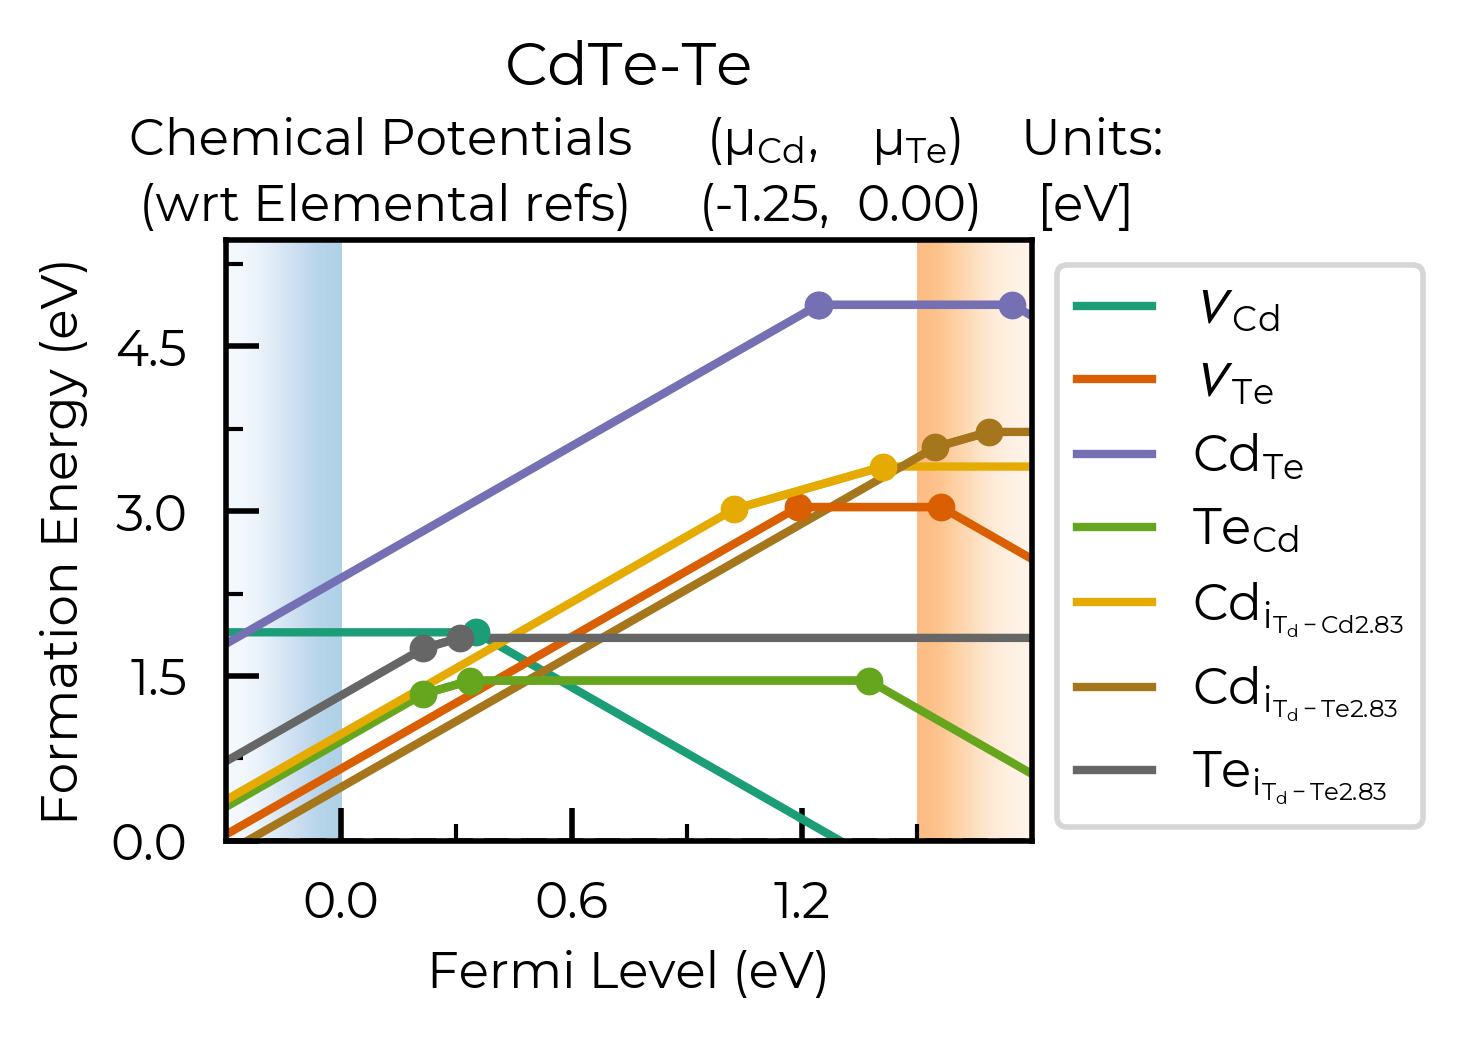

In [3]:
CdTe_thermo.dist_tol = 2
plot = CdTe_thermo.plot(limit="Te-rich")

```{tip}
As shown above, can specify the chemical potential limit at which to obtain and plot the defect formation energies using the ``limit`` parameter, which we can set to either ``"X-rich"/"X-poor"`` where X is an element in the system, in which case the most X-rich/poor limit will be used (e.g. "Cd-rich"), or a key in the ``chempots["limits"]`` dictionary (e.g. ``"Cd-CdTe"`` from that shown above). Alternatively, one can also provide a single chemical potential limit in the form of a dictonary to the ``DefectThermodynamics`` methods – see docstrings for more details.
``` 

### Dopability Limits

As a first analysis of the dopability of our system, we can use the `get_doability_limits()` and `get_doping_windows()` methods of the `DefectThermodynamics` object, to determine our n/p-type doping limits:

In [4]:
CdTe_thermo.get_dopability_limits()

,limit,Compensating Defect,Dopability Limit (eV from VBM/CBM)
p-type,Te-rich (CdTe-Te),Cd_i_Td_Te2.83_+2,-0.244
n-type,Cd-rich (Cd-CdTe),v_Cd_-2,1.925


In [5]:
CdTe_thermo.get_doping_windows()

,limit,Compensating Defect,Doping Window (eV at VBM/CBM)
p-type,Te-rich (CdTe-Te),Cd_i_Td_Te2.83_+2,0.489
n-type,Cd-rich (Cd-CdTe),v_Cd_-2,0.853


These values are explained in more detail in the docstrings, but essentially they give us a rough estimate of the _p_/_n_-type dopability of our system, based on the native defect thermodynamics. The dopability limits are defined as the Fermi level positions at which the lowest-energy compensating defect becomes zero, while the doping windows are the energies of the lowest-energy compensating defects at the corresponding band-edge (VBM/CBM).

```{tip}
A large doping window or a dopability limit far from the band-edge position indicates high dopability for that carrier type (i.e. that the system is likely easier to dope _p_/_n_-type).
```

For example here we see that $Cd_{i}^{+2}$ (coordinated by Te anions) is our dominant (lowest-energy) compensating native donor under _p_-type (Te-rich) conditions, and we can see the doping window of 0.49 eV corresponds to its formation energy at the VBM under Te-rich conditions in the plot above.
Meanwhile, $V_{Cd}^{-2}$ is our dominant native compensating acceptor under _n_-type (Cd-rich) conditions. From this initial analysis, we can see that our native defect thermodynamics suggests that CdTe is more _n_-type dopable than _p_-type dopable (having alarger _n_-type doping window/limit).

## Doping Calculations

The above analysis can give a useful qualitative picture of the expected dopability of our material, but we can go on to directly calculate the predicted defect/carrier concentrations and Fermi level positions under various conditions.

To quantitatively analyse the electronic (doping) behaviour of defects in our material, we need the electronic density of states of the bulk material. Usually this is performed as a calculation of the primitive cell, with dense _k_-point sampling for a converged DOS (see [vaspup2.0](https://github.com/kavanase/vaspup2.0?tab=readme-ov-file#density-of-states-and-absorption-spectrum-convergence)) and an accurate band gap (using SOC etc if necessary). The DOS band gap should match that of your `DefectThermodynamics` object/plot. 

The `fermi_dos` parameter is used to specify our calculated electronic density of states (DOS) in the `doped` thermodynamics functions, where this can be either a path to a `vasprun.xml(.gz)` file of the DOS calculation, or a pre-parsed `FermiDos` object to speed up analysis when analysing a range of conditions:

```python
fermi_dos = CdTe_thermo._parse_fermi_dos("CdTe_prim_k181818_NKRED_2_vasprun.xml.gz")
dumpfn(fermi_dos, "CdTe_prim_k181818_NKRED_2_fermi_dos.json")
```

In [2]:
from monty.serialization import loadfn  # load our pre-parsed example FermiDos object
fermi_dos = loadfn("CdTe/CdTe_prim_k181818_NKRED_2_fermi_dos.json")

Let's first plot the carrier concentrations versus Fermi level in our material, to see what sort of Fermi level position we would need to obtain a target free carrier concentration etc. Here for CdTe, we'll plot these quantities at 300K (room temperature) and 875K (a typical annealing temperature):

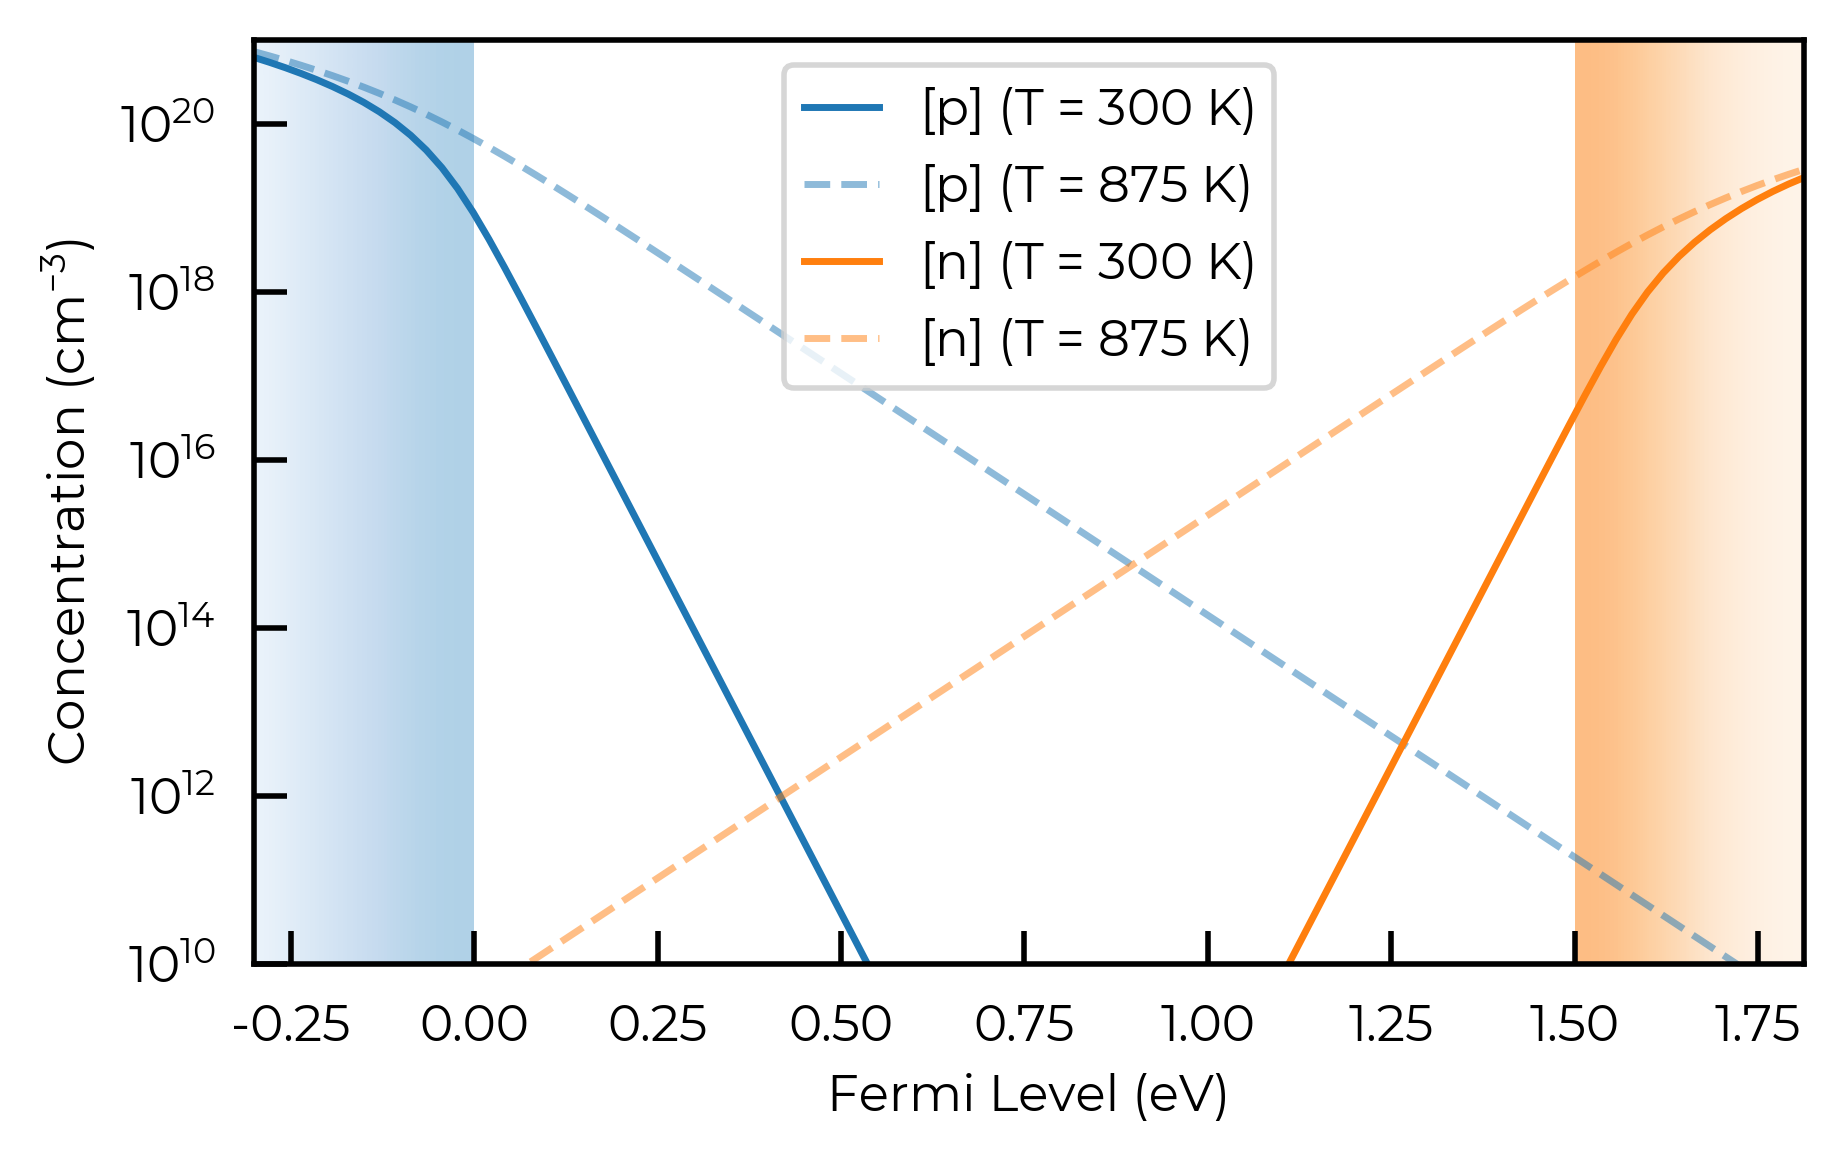

In [7]:
from doped.thermodynamics import get_e_h_concs
import numpy as np
import matplotlib.pyplot as plt

f,ax = plt.subplots(figsize=(5,3))
band_gap = fermi_dos.get_gap(tol=1e-6)
e_concs = []; h_concs = []; fermi_levels = np.linspace(-0.3, band_gap + 0.3, 100)
high_temp_e_concs = []; high_temp_h_concs = []
for fermi_level in fermi_levels:
    e_conc, h_conc = get_e_h_concs(
        fermi_dos=fermi_dos, fermi_level=CdTe_thermo.vbm + fermi_level, temperature=300)
    e_concs.append(e_conc); h_concs.append(h_conc)
    e_conc, h_conc = get_e_h_concs(
        fermi_dos=fermi_dos, fermi_level=CdTe_thermo.vbm + fermi_level, temperature=875)
    high_temp_e_concs.append(e_conc); high_temp_h_concs.append(h_conc)

ax.plot(fermi_levels, h_concs, label="$[p]$ ($T$ = 300 K)", color="C0")
ax.plot(fermi_levels, high_temp_h_concs, label="$[p]$ ($T$ = 875 K)", color="C0", ls="--", alpha=0.5)
ax.plot(fermi_levels, e_concs, label="$[n]$ ($T$ = 300 K)", color="C1")
ax.plot(fermi_levels, high_temp_e_concs, label="$[n]$ ($T$ = 875 K)", color="C1", ls="--", alpha=0.5)
ax.set_xlabel("Fermi Level (eV)"); ax.set_ylabel("Concentration (cm$^{-3}$)")
ax.legend(); ax.semilogy()

# show VB in blue from -0.3 to 0 eV and CB in orange from CBM to CBM + 0.3 eV:
ax.imshow([(0, 1), (0, 1)], cmap=plt.cm.Blues, extent=(ax.get_xlim()[0], 0, ax.get_ylim()[1], ax.get_ylim()[0]),
          vmin=0, vmax=3, interpolation="bicubic", rasterized=True, aspect="auto")

ax.imshow([(1, 0), (1, 0)], cmap=plt.cm.Oranges, extent=(1.5, band_gap + 0.3, ax.get_ylim()[0], ax.get_ylim()[1]),
          vmin=0, vmax=3, interpolation="bicubic", rasterized=True, aspect="auto")
ax.set_xlim(-0.3, band_gap + 0.3); ax.set_ylim(1e10, 1e21);  # set axis limits

Nice! Here we can see a clear disparity in the _n_-type and _p_-type carrier concentrations, where the hole concentration is significantly higher than the electron concentration for the same energy separation of the Fermi level with the corresponding band edge (VBM/CBM), which is a direct result of the significantly higher DOS at the VBM in CdTe compared to the CBM. 

```{tip}
By tracking the Fermi level & carrier concentration during annealing and upon cooling, this plot above can be used to analyse the type of compensation occurring for a given system (i.e. electronic, ionic or mixed). 
Given the annealing Fermi level & carrier concentration as a starting point, upon cooling it will either move horizontally to retain the carrier concentration while shifting the Fermi level closer to the band edge for full electronic compensation, move vertically downwards to decrease carrier concentrations at the same/similar Fermi level if you have self-compensation at that Fermi level, or somewhere in-between for compensation by other defects / self-compensation at a different Fermi level position / mixed electronic-ionic compensation.
```

### CdTe: Cd-Rich

Let's first look at the carrier and defect calculations in CdTe at the Cd-rich (i.e. most _n_-type) chemical potential limit, as a function of the device annealing/growth temperature.

The formation energies of charged defects in a material depend on the electronic chemical potential (i.e. the Fermi level), which in turn depends on the net population of all charged defects in the system. The equilibrium concentrations of charged point defects are therefore mutually dependent, and so the equilibrium Fermi level position must be solved self-consistently. Typically this is done by imposing the constraint of net charge-neutrality, and solving for the Fermi level which satisfies this condition – as implemented in `doped`. 

```{tip}
In most cases, materials are synthesised or processed under elevated temperatures ('annealing'), before being cooled ('quenched') to the device operating temperature. Due to the exponential temperature dependence of equilibrium defect concentration and greater availability of thermal energy, it is generally expected that most defects will be created during the initial high-temperature annealing step, with their total concentration then remaining fixed due to kinetic trapping upon cooling — this being known as the 'frozen defect approximation'.

While the total concentration of each defect is assumed to be fixed upon cooling within this approach, the Fermi level and thus _relative_ populations of different defect charge states and carrier concentrations re-equilibrate upon cooling (under the constraint of fixed total concentration for each defect), which again is solved self-consistently using the net charge neutrality condition and the constrained defect concentrations.
```

In [8]:
import numpy as np
anneal_temperatures = np.arange(200, 1401, 50)  # annealing temperatures to consider, in K
annealing_dict = {}

for anneal_temp in anneal_temperatures:
    fermi_level, e_conc, h_conc, conc_df = CdTe_thermo.get_quenched_fermi_level_and_concentrations(
        bulk_dos_vr=fermi_dos, limit="Cd-rich", annealing_temperature=anneal_temp
    )  # quenching to 300K (default) – alternatively can specify quench (operating) temperature
    annealing_fermi_level, annealing_e_conc, annealing_h_conc = CdTe_thermo.get_equilibrium_fermi_level(
            bulk_dos_vr=fermi_dos, limit="Cd-rich", temperature=anneal_temp, return_concs=True,
    )
    annealing_dict[anneal_temp] = {
        "annealing_fermi_level": annealing_fermi_level,
        "annealing_e_conc": annealing_e_conc,
        "annealing_h_conc": annealing_h_conc,
        "fermi_level": fermi_level,
        "e_conc": e_conc,
        "h_conc": h_conc,
        "conc_df": conc_df
    }

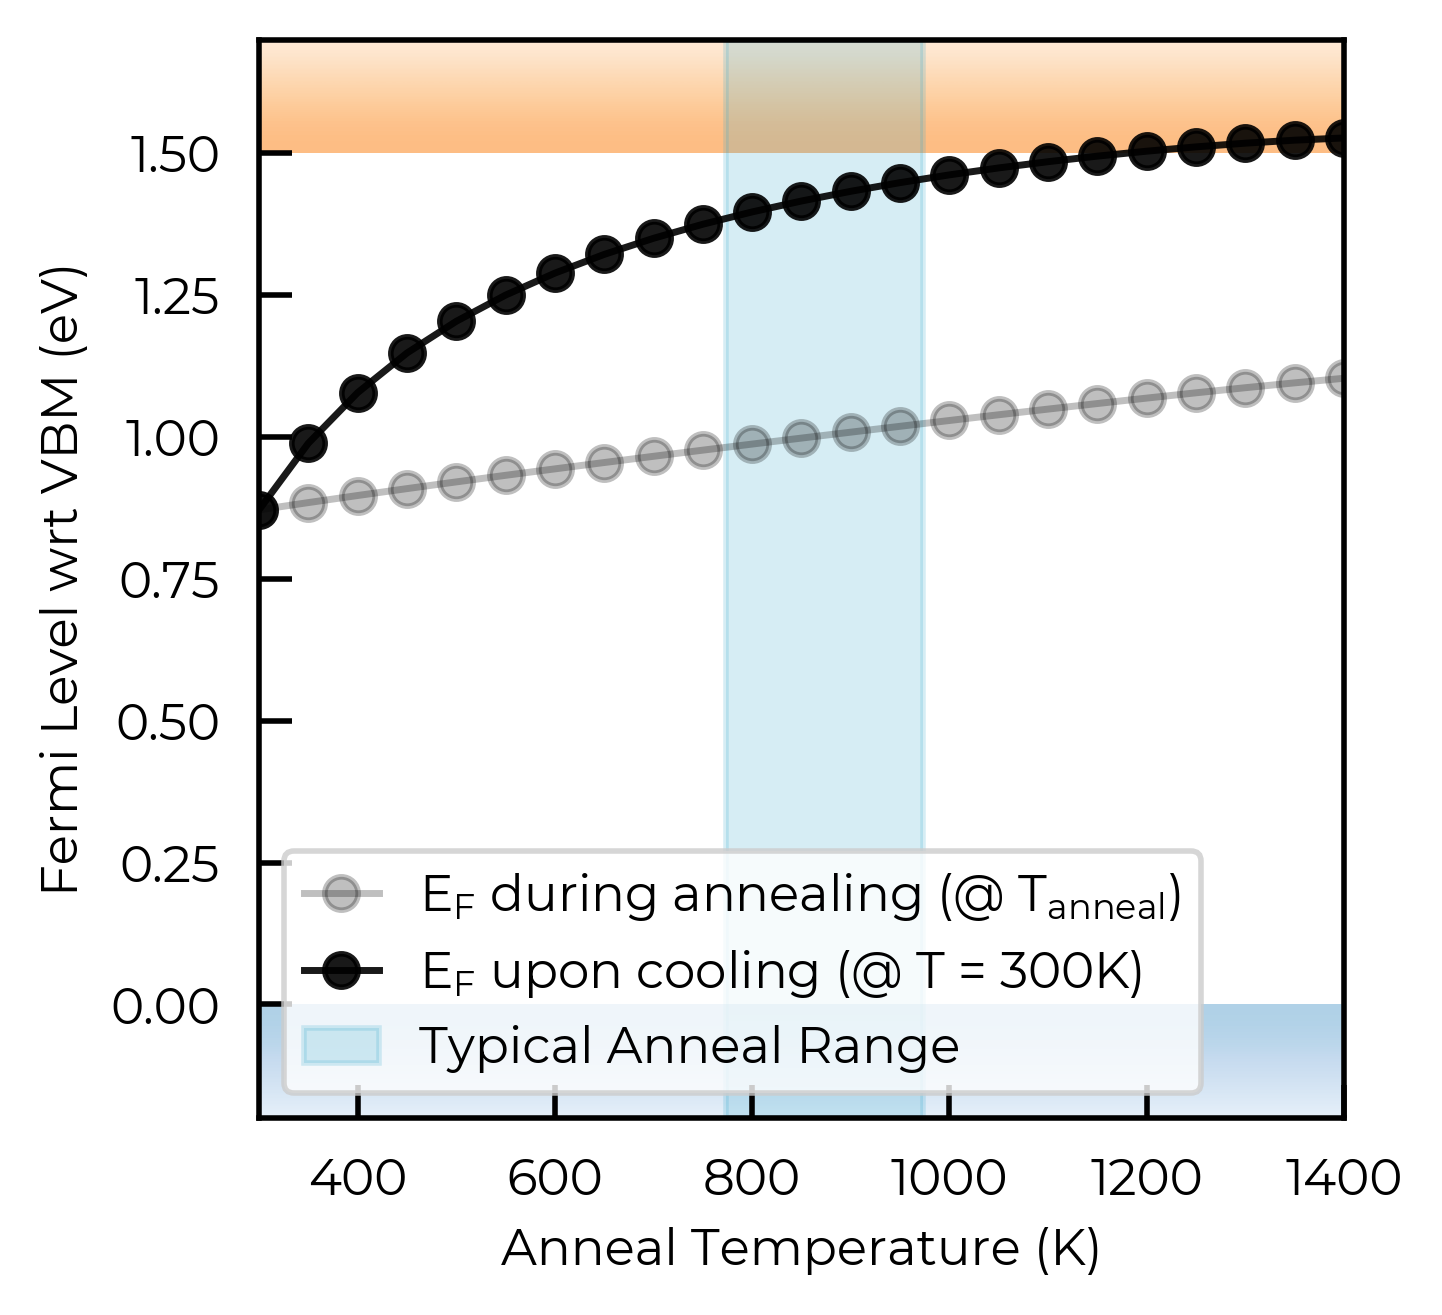

In [9]:
import matplotlib.pyplot as plt
f,ax = plt.subplots()

anneal_fermi_levels = np.array([v["annealing_fermi_level"] for k, v in annealing_dict.items()])
quenched_fermi_levels = np.array([v["fermi_level"] for k, v in annealing_dict.items()])
ax.plot(anneal_temperatures, anneal_fermi_levels, marker='o',
        label="$E_F$ during annealing (@ $T_{anneal}$)", color = "k", alpha=0.25)
ax.plot(anneal_temperatures, quenched_fermi_levels, marker='o',
        label="$E_F$ upon cooling (@ $T$ = 300K)", color = "k", alpha=0.9)
ax.set_xlabel('Anneal Temperature (K)')
ax.set_ylabel('Fermi Level wrt VBM (eV)')
ax.set_xlim(300, 1400)
ax.axvspan(500+273.15, 700+273.15, alpha=0.2, color='#33A7CC', label="Typical Anneal Range")
ax.legend()

# show VB in blue and CB in orange:
ax.imshow([(1, 1), (0, 0)], cmap=plt.cm.Blues, extent=(ax.get_xlim()[0], ax.get_xlim()[1], -0.3, 0),
          vmin=0, vmax=3, interpolation="bicubic", rasterized=True, aspect="auto")
ax.imshow([(0, 0,), (1, 1)], cmap=plt.cm.Oranges, extent=(ax.get_xlim()[0], ax.get_xlim()[1], 1.5, 1.8),
          vmin=0, vmax=3, interpolation="bicubic", rasterized=True, aspect="auto",)
ax.set_ylim(-0.2, 1.7)
plt.show()

In [10]:
print(f"Room-temp Fermi level for T_anneal = {anneal_temperatures[16]} K: {quenched_fermi_levels[16]:.2f} eV above VBM")

Room-temp Fermi level for T_anneal = 1000 K: 1.46 eV above VBM


Let's plot the defect/carrier concentrations:

In [11]:
annealing_n = np.array([annealing_dict[k]["annealing_e_conc"] for k in anneal_temperatures])
annealing_p = np.array([annealing_dict[k]["annealing_h_conc"] for k in anneal_temperatures])
quenched_n = np.array([annealing_dict[k]["e_conc"] for k in anneal_temperatures])
quenched_p = np.array([annealing_dict[k]["h_conc"] for k in anneal_temperatures])

def _array_from_df(name, annealing_dict, anneal_temperatures):
    return np.array([annealing_dict[temp]["conc_df"][
                         (annealing_dict[temp]["conc_df"]["Defect"] == name) &
                         (annealing_dict[temp]["conc_df"]["Charge"] == 0)
                    ]["Total Concentration (cm^-3)"].to_numpy()[0] for temp in anneal_temperatures])

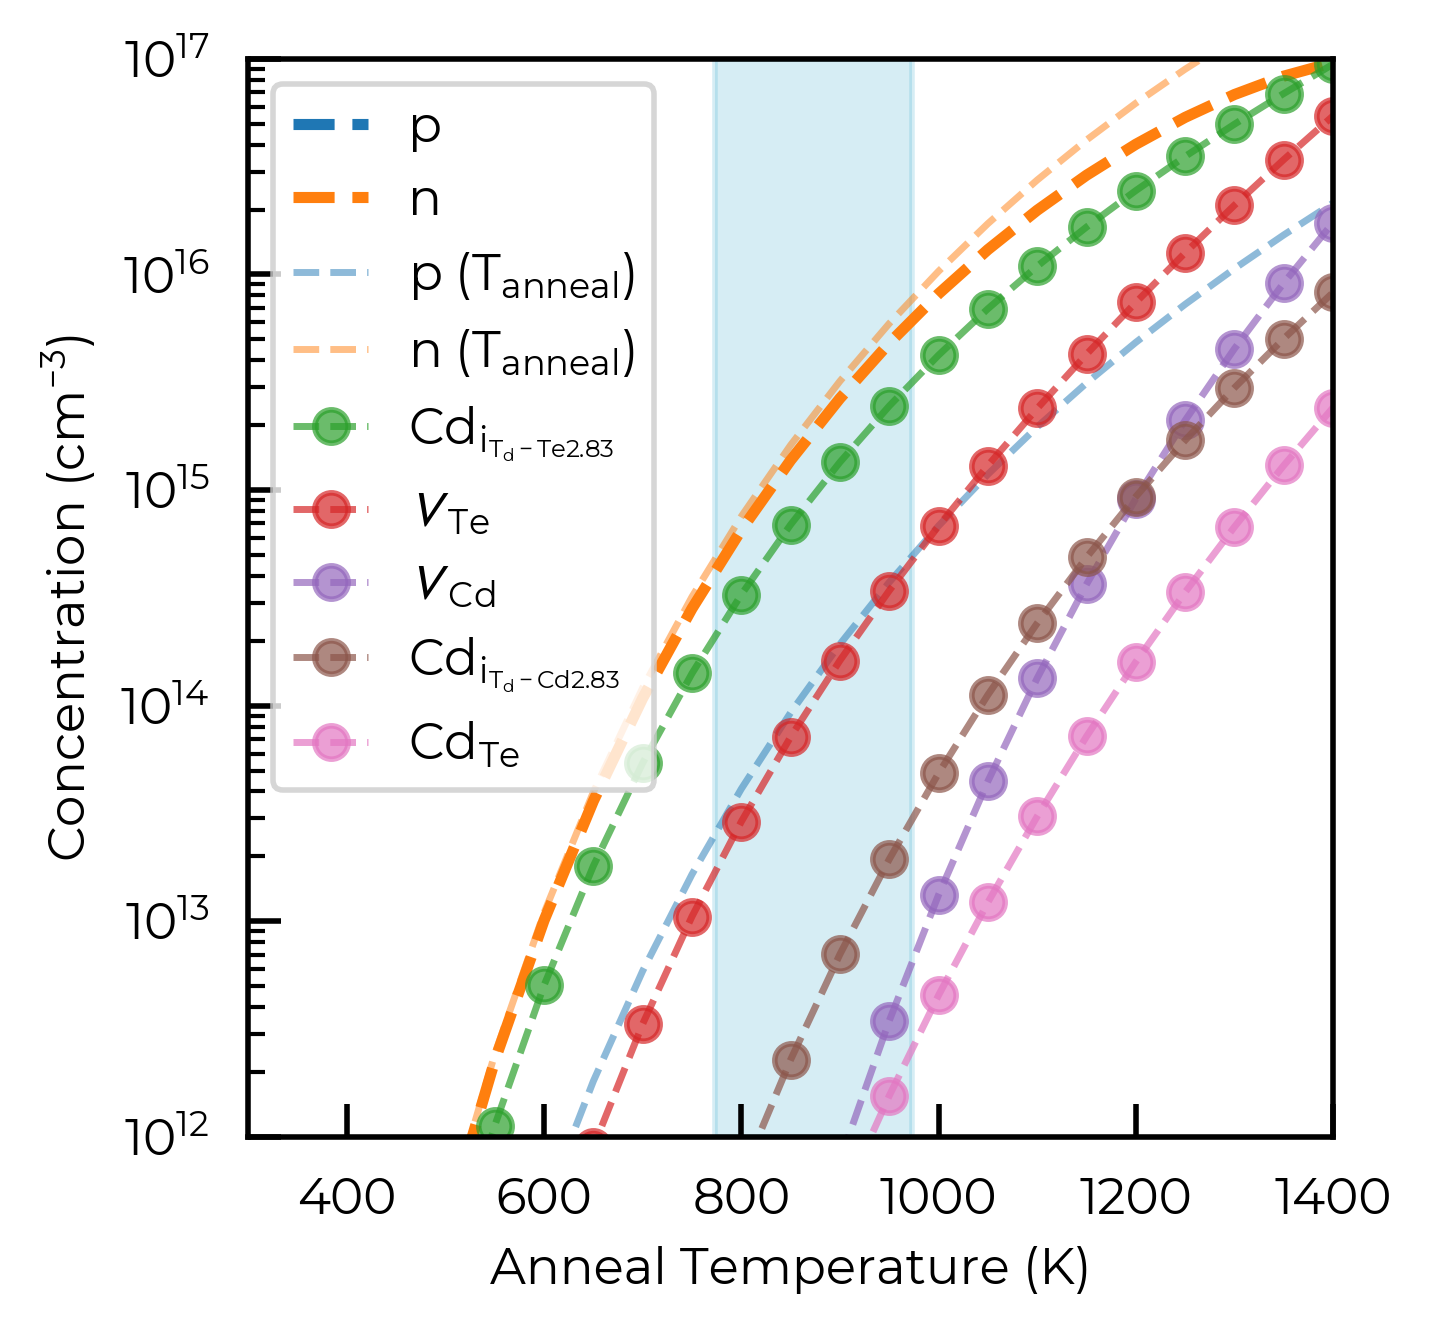

In [12]:
from doped.utils.plotting import format_defect_name
f, ax = plt.subplots()

ax.plot(anneal_temperatures, quenched_p, label='p', linestyle="--", lw=2)  # plot p/n (room temp)
ax.plot(anneal_temperatures, quenched_n, label='n', linestyle="--", lw=2)
ax.plot(anneal_temperatures, annealing_p, label='p ($T_{anneal}$)', alpha=0.5, c = "C0", linestyle="--")
ax.plot(anneal_temperatures, annealing_n, label='n ($T_{anneal}$)', alpha=0.5, c = "C1", linestyle="--")

# only plotting defects with significant concentrations here (>10^12 cm^-3 at T=1350K):
conc_df = annealing_dict[1350]["conc_df"]
defects_concs = {(defect, conc_df[conc_df["Defect"] == defect][
    "Total Concentration (cm^-3)"].to_numpy()[0]) for defect in conc_df["Defect"]}
defects_concs = sorted(defects_concs, key = lambda x: x[1], reverse=True)  # sort by concentration
significant_defects = [defect for defect, conc in defects_concs if conc > 1e12]  # cut <10^12 cm^-3

for defect in significant_defects:
    ax.plot(anneal_temperatures, _array_from_df(defect, annealing_dict, anneal_temperatures), 
            label=format_defect_name(defect, include_site_info_in_name=True, wout_charge=True), alpha=0.7, linestyle="--", marker="o")

ax.set_xlabel('Anneal Temperature (K)'); ax.set_ylabel(r"Concentration (cm$^{-3}$)")
ax.set_yscale("log")  # log scale
ax.set_xlim(300, 1400); ax.set_ylim(1e12, 1e17)
ax.axvspan(500+273.15, 700+273.15, alpha=0.2, color='#33A7CC')  # shade in typical anneal range
ax.legend()
plt.show()

Here we see we get exponential increases in _n_-type carrier concentration with increasing annealing temperature, as expected, and that the electron concentration primarily originates from $Cd_{i}^{+2}$ donors (our lowest energy native donor under Cd-rich conditions), with the electron concentration approximately matching the concentration of $Cd_{i}^{+2}$ (with a factor of 2x) at high temperatures. 

```{tip}
If we had some digitised experimental data then we could also plot together here with our predicted datapoints, as scatter points.
```

We can of course perform the same analysis for the _p_-type (Te-rich) limit, or other chemical potential limits / doping conditions. For instance, if we had also calculated the formation energies of extrinsic dopants/impurities, then we could similarly calculate the predicted dopant/defect/carrier concentrations in the presence of these impurities, under various growth conditions. 

### CdTe: Approximating Temperature-Dependent Band Gap

As with all semiconducting/insulating materials, the band gap (and thus relative energies of defects and charge carriers) in CdTe is dependent on the temperature. These changes in the band edge positions can affect the defect/carrier formation energies & concentrations, and thus the Fermi level position / doping behaviour. In `doped`, we can accounted for these changes in band edge positions (if known) using the `delta_gap` parameter in the `get_quenched_fermi_level_and_concentrations()` method and/or the `scissor_dos()` function as shown below.

Of course, there are many effects of temperature on the free energies of defect formation (e.g. see [Mosquera-Lois et al. _Chem Soc Rev_ 2023](https://doi.org/10.1039/D3CS00432E)), but here for a crude first approximation we will account for the experimentally-known band gap renormalisation of CdTe as a function of temperature, assuming that the renormalisation occurs symmetrically such that the VBM and CBM eigenvalues are down/up-shifted by the same amount (ΔEg/2) at each temperature while the defect formation energies / transition levels remain fixed.

To do this, we first define a function for the temperature-dependent band gap, by fitting to the experimental data:  

In [3]:
import numpy as np
band_gap_data =[(1.5110277123929035, 293.61411498177165),  # CdTe gap vs Temp, Belas et al. 2014
             (1.4978368122096875, 323.8690412012745),
             (1.4771103223451387, 372.54000946743133),
             (1.4544939046587835, 422.5264093083491),
             (1.4328236569636261, 472.5128091492669),
             (1.411153409268469, 522.4992089901847),
             (1.3885345794215245, 571.1701772563415),
             (1.3668667438869564, 622.4720086720203),
             (1.3451964961917993, 672.4584085129379),
             (1.3235262484966421, 722.4448083538558),
             (1.3009098308102867, 772.4312081947735),
             (1.2792395831151295, 822.4176080356914),
             (1.2575693354199722, 872.4040078766092),
             (1.235899087724815, 922.390407717527),
             (1.2142288400296577, 972.3768075584447),
             (1.1925585923345006, 1022.3632073993625),
             (1.1699421746481453, 1072.3496072402804),
             (1.148271926952988, 1122.3360070811982),
             (1.1266016792578308, 1172.322406922116),
             (1.1039876737320649, 1223.6242383377944)]

params = np.polyfit([x[1] for x in band_gap_data], [x[0] for x in band_gap_data], 1, full=True)[0]

def band_gap_linear_fit(T):  # linear fit of the CdTe experimental band gap vs T
    return params[1] + params[0] * T

# alternatively we could also use a Cubic Spline fit such as this (or any other fitted function):
# from scipy.interpolate import CubicSpline
# band_gap_spline_fit = CubicSpline([x[1] for x in band_gap_data], [x[0] for x in band_gap_data])

Let's quickly plot the experimental data and our linear fit, to confirm it looks reasonable:

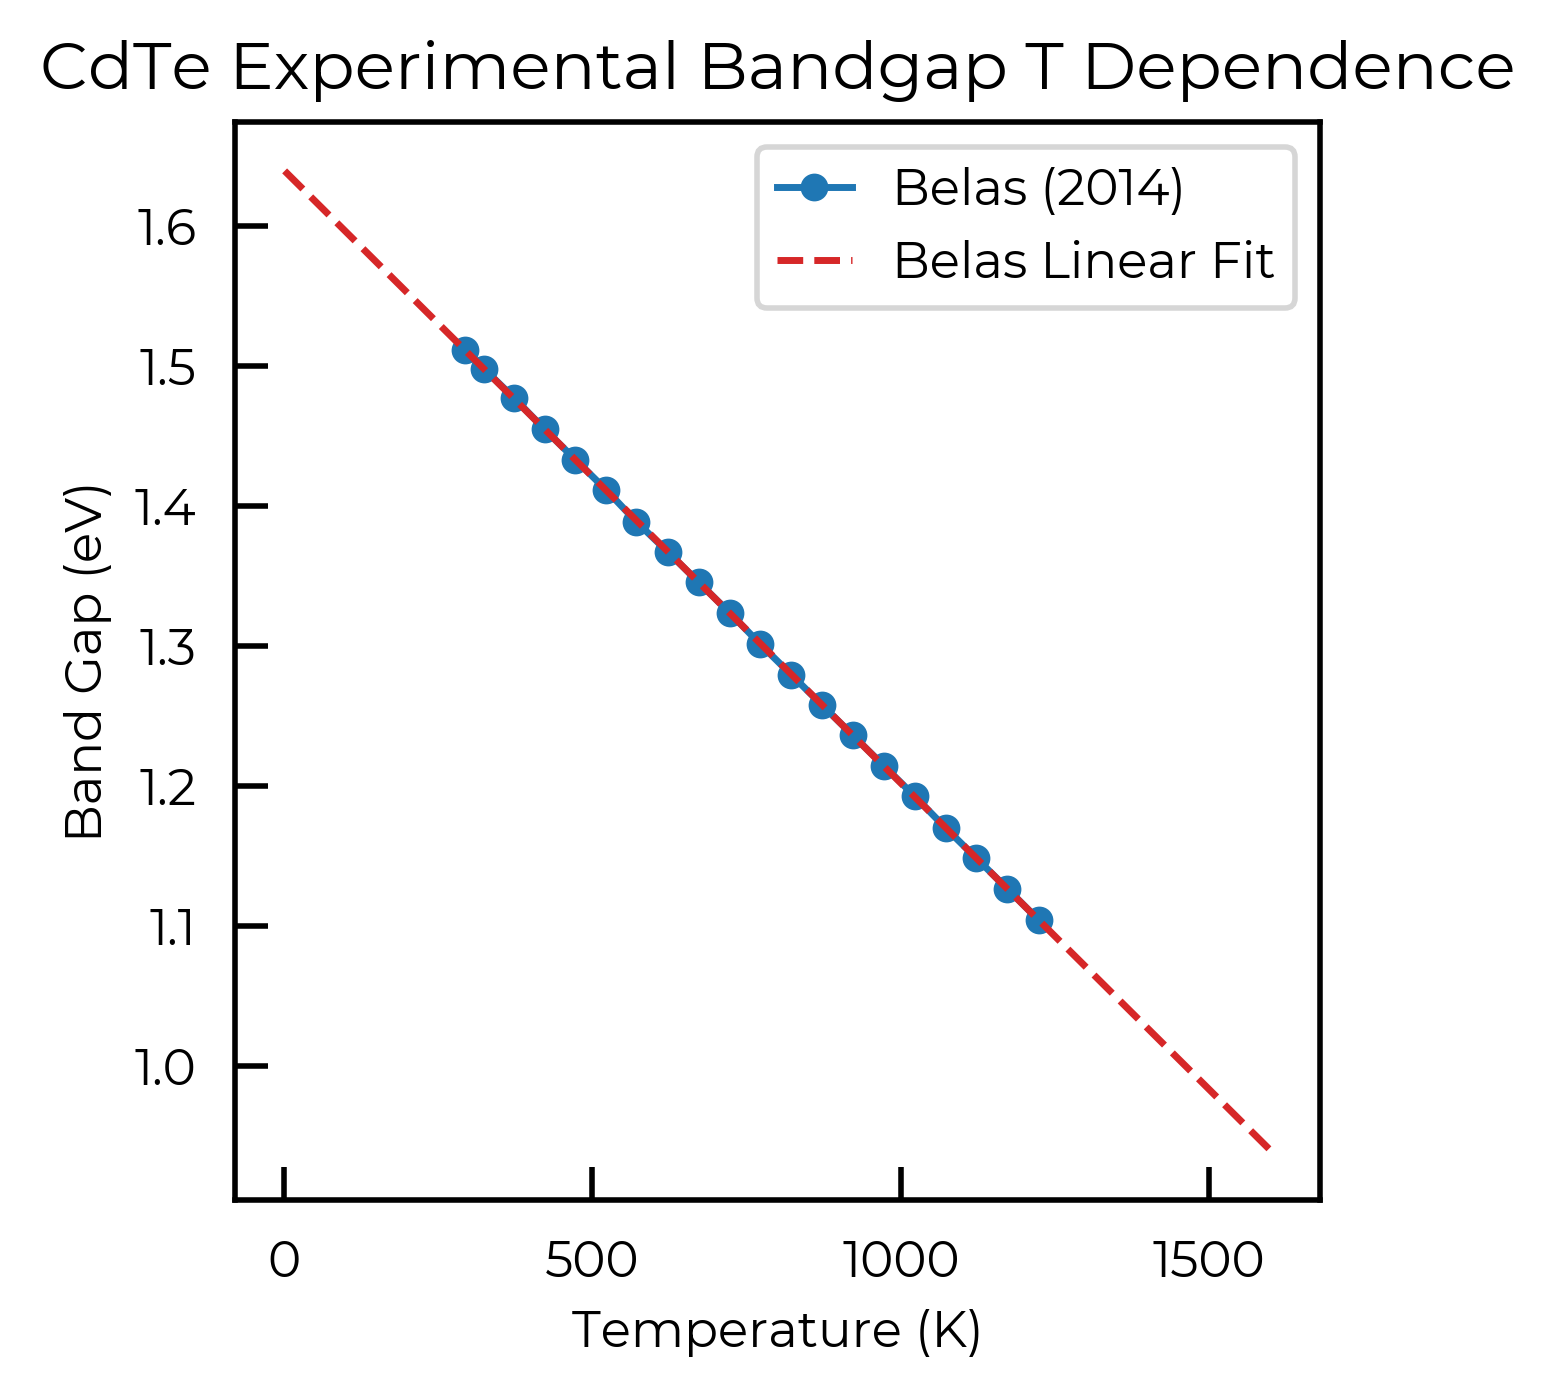

In [14]:
f,ax = plt.subplots()

temps = np.linspace(1, 1600, num=1000)
ax.plot([x[1] for x in band_gap_data], [x[0] for x in band_gap_data], 
        label = "Belas (2014)", marker="o", markersize=4)
ax.plot(temps, band_gap_linear_fit(temps), color="C3", ls="--", label="Belas Linear Fit")
ax.set_xlabel("Temperature (K)"); ax.set_ylabel("Band Gap (eV)")
ax.set_title("CdTe Experimental Bandgap T Dependence")
ax.legend()
plt.show()

Now we use this function to set our `delta_gap` parameter in the `get_quenched_fermi_level_and_concentrations()` method, to account for the temperature-dependent band gap shift:

#### CdTe: Te-Rich with Temperature Dependence

In [15]:
from doped.thermodynamics import scissor_dos
anneal_temperatures = np.arange(200, 1401, 50)  # annealing temperatures to consider, in K
annealing_dict = {}

for anneal_temp in anneal_temperatures:
    band_gap_shift = band_gap_linear_fit(anneal_temp) - 1.5  # 1.5 eV is our DFT (and room temp) gap
    fermi_level, e_conc, h_conc, conc_df = CdTe_thermo.get_quenched_fermi_level_and_concentrations(
        bulk_dos_vr=fermi_dos, limit="Te-rich", annealing_temperature=anneal_temp, delta_gap=band_gap_shift,
    )  # Note that we now use `delta_gap` which specifies the change in gap from the original DFT DOS to the anneal temp
    scissored_dos = scissor_dos(delta_gap=band_gap_shift, dos=fermi_dos, verbose=False)  # symmetrically-renormalised DOS -> to get the Fermi level & e/h concentrations at the annealing temperature:
    annealing_fermi_level, annealing_e_conc, annealing_h_conc = CdTe_thermo.get_equilibrium_fermi_level(
            bulk_dos_vr=scissored_dos, limit="Te-rich", temperature=anneal_temp, return_concs=True,
    )
    
    annealing_dict[anneal_temp] = {
        "annealing_fermi_level": annealing_fermi_level,
        "annealing_e_conc": annealing_e_conc,
        "annealing_h_conc": annealing_h_conc,
        "fermi_level": fermi_level,
        "e_conc": e_conc,
        "h_conc": h_conc,
        "conc_df": conc_df
    }

Plot the Fermi level (during annealing & upon cooling), and the simulated band edges:

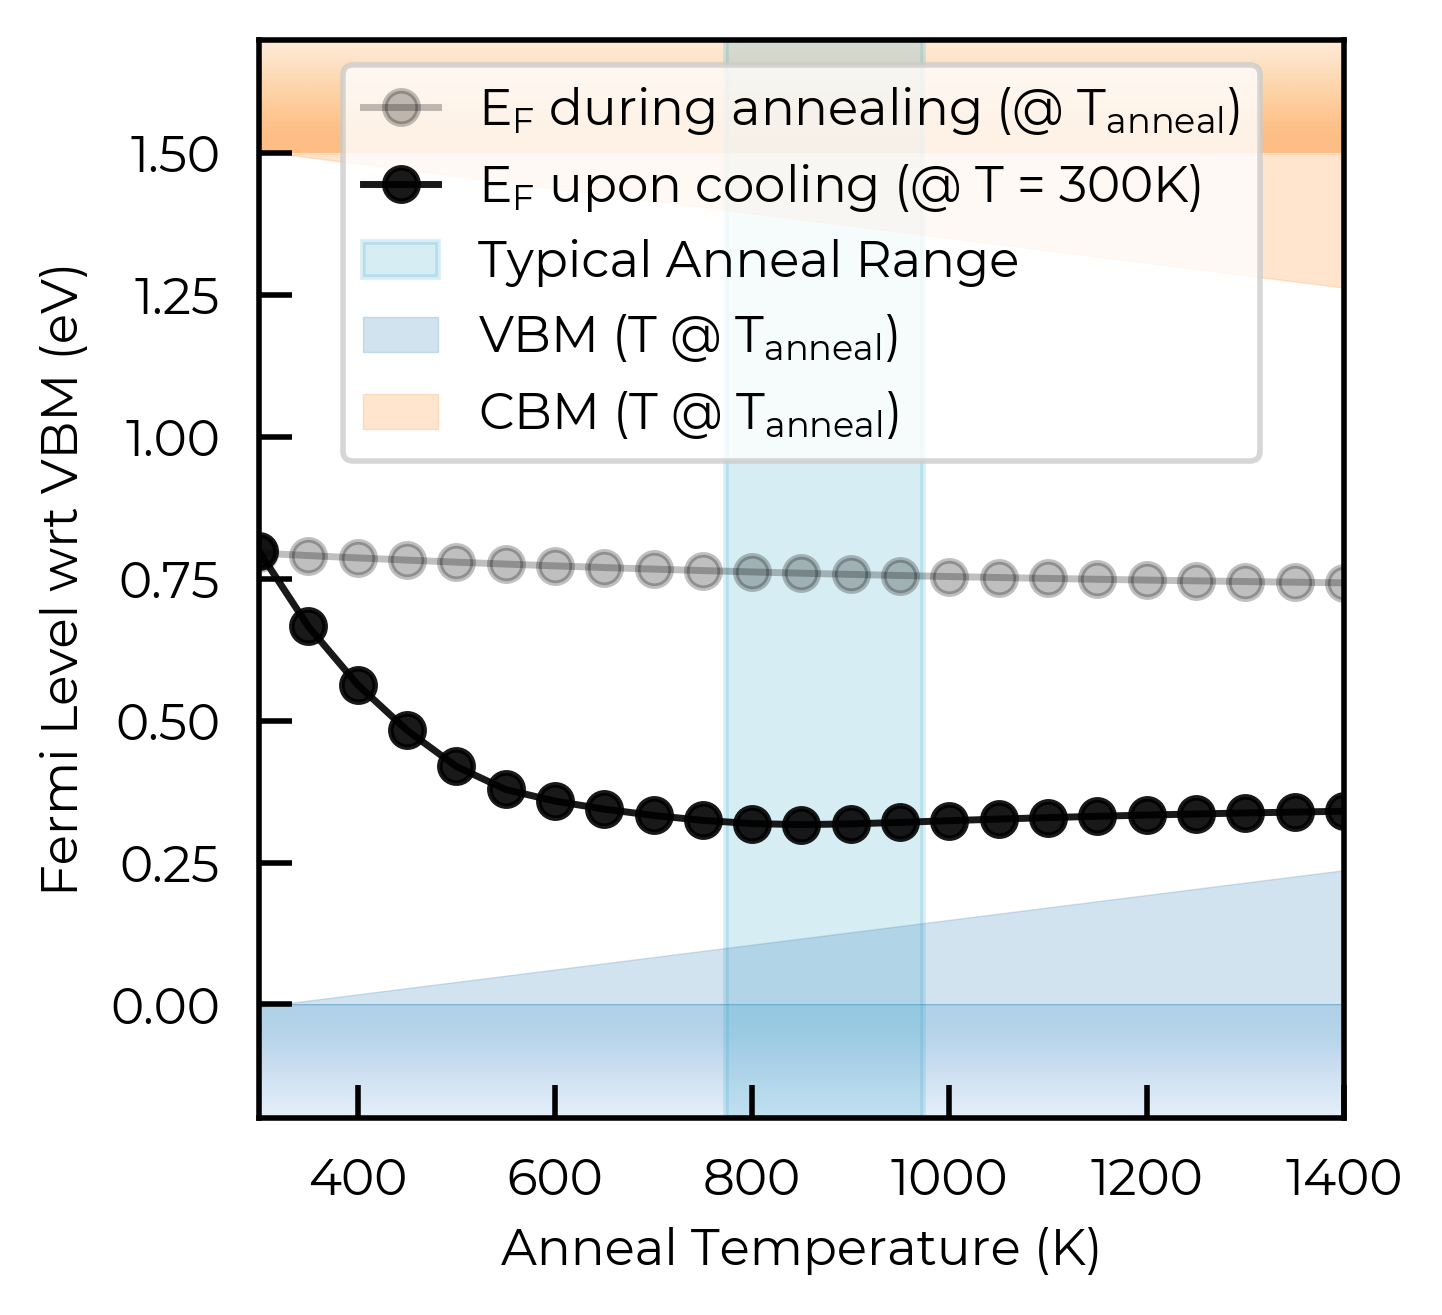

In [16]:
import matplotlib.pyplot as plt
f,ax = plt.subplots()

anneal_fermi_levels = np.array([v["annealing_fermi_level"] for k, v in annealing_dict.items()])
quenched_fermi_levels = np.array([v["fermi_level"] for k, v in annealing_dict.items()])
ax.plot(anneal_temperatures, anneal_fermi_levels, marker='o',
        label="$E_F$ during annealing (@ $T_{anneal}$)", color = "k", alpha=0.25)
ax.plot(anneal_temperatures, quenched_fermi_levels, marker='o',
        label="$E_F$ upon cooling (@ $T$ = 300K)", color = "k", alpha=0.9)
ax.set_xlabel('Anneal Temperature (K)')
ax.set_ylabel('Fermi Level wrt VBM (eV)')
ax.set_xlim(300, 1400)
ax.axvspan(500+273.15, 700+273.15, alpha=0.2, color='#33A7CC', label="Typical Anneal Range")
ax.fill_between(anneal_temperatures, (1.5 - band_gap_linear_fit(anneal_temperatures))/2,
                0, alpha=0.2, color="C0", label="VBM (T @ $T_{anneal}$)", linewidth=0.25,)
ax.fill_between(anneal_temperatures, 1.5 - (1.5 - band_gap_linear_fit(anneal_temperatures))/2,
                1.5, alpha=0.2, color="C1", label="CBM (T @ $T_{anneal}$)", linewidth=0.25,)
ax.legend(loc="upper center")

# show VB in blue and CB in orange:
ax.imshow([(1, 1), (0, 0)], cmap=plt.cm.Blues, extent=(ax.get_xlim()[0], ax.get_xlim()[1], -0.3, 0),
          vmin=0, vmax=3, interpolation="bicubic", rasterized=True, aspect="auto")
ax.imshow([(0, 0,), (1, 1)], cmap=plt.cm.Oranges, extent=(ax.get_xlim()[0], ax.get_xlim()[1], 1.5, 1.8),
          vmin=0, vmax=3, interpolation="bicubic", rasterized=True, aspect="auto",)
ax.set_ylim(-0.2, 1.7)
plt.show()

In [17]:
print(f"Room-temp Fermi level for T_anneal = {anneal_temperatures[16]} K: {quenched_fermi_levels[16]:.2f} eV above VBM")

Room-temp Fermi level for T_anneal = 1000 K: 0.32 eV above VBM


Let's plot the defect/carrier concentrations:

In [18]:
annealing_n = np.array([annealing_dict[k]["annealing_e_conc"] for k in anneal_temperatures])
annealing_p = np.array([annealing_dict[k]["annealing_h_conc"] for k in anneal_temperatures])
quenched_n = np.array([annealing_dict[k]["e_conc"] for k in anneal_temperatures])
quenched_p = np.array([annealing_dict[k]["h_conc"] for k in anneal_temperatures])

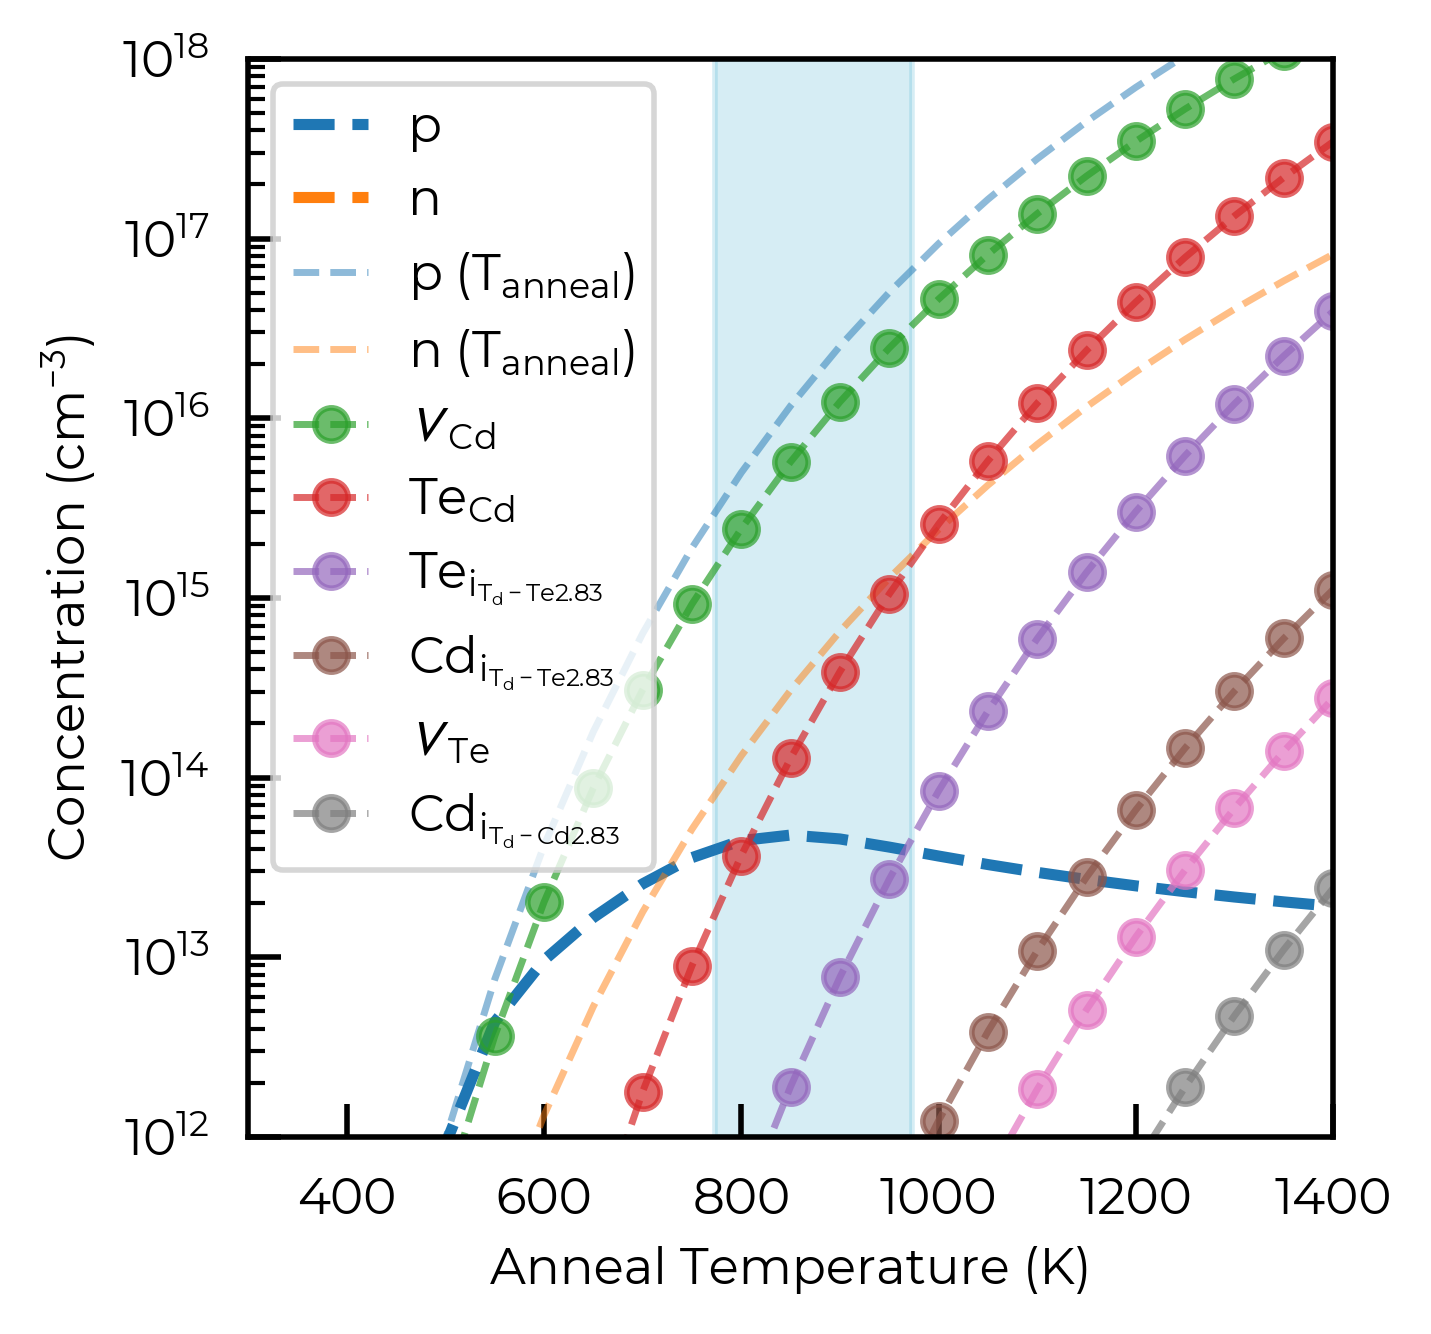

In [19]:
from doped.utils.plotting import format_defect_name
f, ax = plt.subplots()

ax.plot(anneal_temperatures, quenched_p, label='p', linestyle="--", lw=2)  # plot p/n (room temp)
ax.plot(anneal_temperatures, quenched_n, label='n', linestyle="--", lw=2)
ax.plot(anneal_temperatures, annealing_p, label='p ($T_{anneal}$)', alpha=0.5, c = "C0", linestyle="--")
ax.plot(anneal_temperatures, annealing_n, label='n ($T_{anneal}$)', alpha=0.5, c = "C1", linestyle="--")

# only plotting defects with significant concentrations here (>10^12 cm^-3 at T=1350K):
conc_df = annealing_dict[1350]["conc_df"]
defects_concs = {(defect, conc_df[conc_df["Defect"] == defect][
    "Total Concentration (cm^-3)"].to_numpy()[0]) for defect in conc_df["Defect"]}
defects_concs = sorted(defects_concs, key = lambda x: x[1], reverse=True)  # sort by concentration
significant_defects = [defect for defect, conc in defects_concs if conc > 1e12]  # cut <10^12 cm^-3

for defect in significant_defects:
    ax.plot(anneal_temperatures, _array_from_df(defect, annealing_dict, anneal_temperatures), 
            label=format_defect_name(defect, include_site_info_in_name=True, wout_charge=True), alpha=0.7, linestyle="--", marker="o")

ax.set_xlabel('Anneal Temperature (K)'); ax.set_ylabel(r"Concentration (cm$^{-3}$)")
ax.set_yscale("log")  # log scale
ax.set_xlim(300, 1400); ax.set_ylim(1e12, 1e18)
ax.axvspan(500+273.15, 700+273.15, alpha=0.2, color='#33A7CC')  # shade in typical anneal range
ax.legend()
plt.show()

Let's compare to some experimental data of _p_ at T-anneal:

In [20]:
wienecke_data = np.array([  # Wienecke et al. 1993
[675.644735186816, 15.19509584755584],
[774.64775443452, 15.983458618047331],
[773.2859479179771, 15.780402388747808],
[876.594540193735, 16.456749859094277],
[866.7316643602969, 16.470175483037483],
[931.3592904767895, 16.68944378653258],
[972.2040508240029, 16.939464368267398],
[1043.955214492389, 17.234473455894925],
[1030.0320795068562, 17.11399747952909],
[1077.6449867907913, 17.335494943226077],
[1082.4820732167568, 17.165318826904443],
    ])
emanuelsson_data = np.array([[750 + 273.15, np.log10(1.2e17)]])  # Emanuelsson et al. 1993
expt_data = np.append(wienecke_data, emanuelsson_data, axis=0)

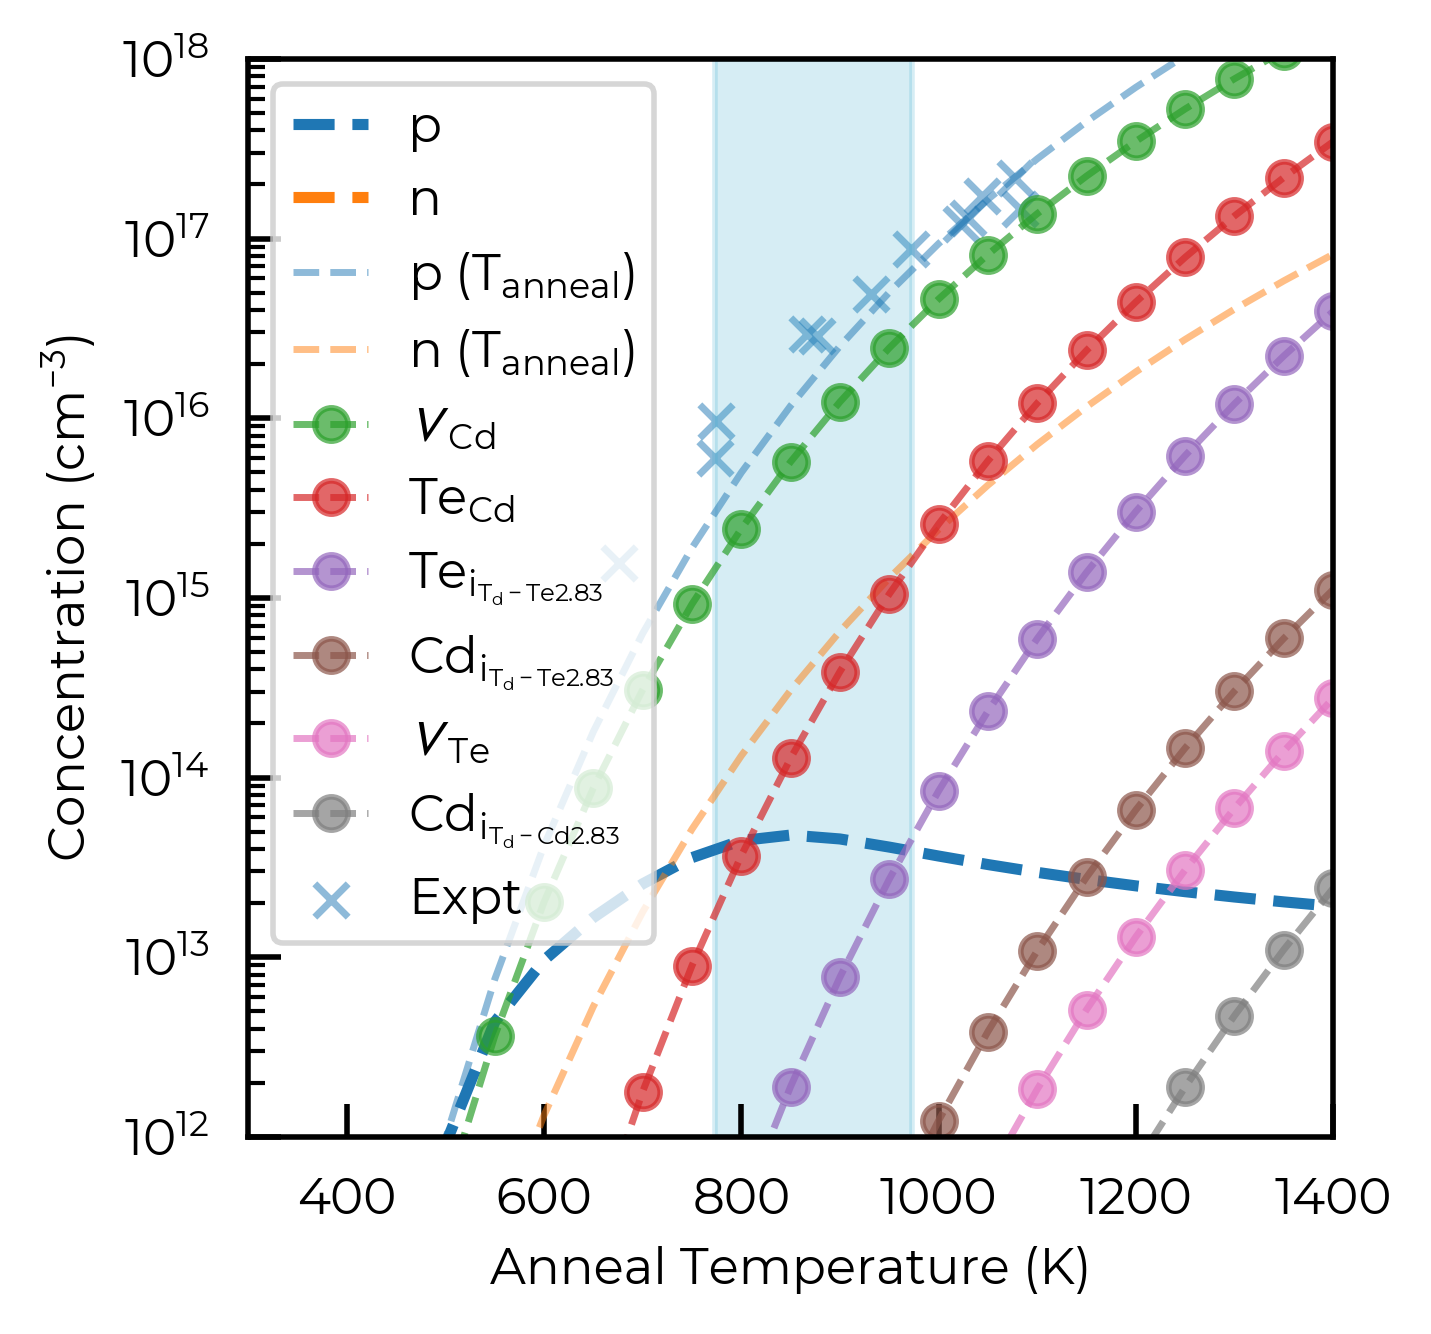

In [21]:
from doped.utils.plotting import format_defect_name
f, ax = plt.subplots()

ax.plot(anneal_temperatures, quenched_p, label='p', linestyle="--", lw=2)  # plot p/n (room temp)
ax.plot(anneal_temperatures, quenched_n, label='n', linestyle="--", lw=2)
ax.plot(anneal_temperatures, annealing_p, label='p ($T_{anneal}$)', alpha=0.5, c = "C0", linestyle="--")
ax.plot(anneal_temperatures, annealing_n, label='n ($T_{anneal}$)', alpha=0.5, c = "C1", linestyle="--")

# only plotting defects with significant concentrations here (>10^12 cm^-3 at T=1350K):
conc_df = annealing_dict[1350]["conc_df"]
defects_concs = {(defect, conc_df[conc_df["Defect"] == defect][
    "Total Concentration (cm^-3)"].to_numpy()[0]) for defect in conc_df["Defect"]}
defects_concs = sorted(defects_concs, key = lambda x: x[1], reverse=True)  # sort by concentration
significant_defects = [defect for defect, conc in defects_concs if conc > 1e12]  # cut <10^12 cm^-3

for defect in significant_defects:
    ax.plot(anneal_temperatures, _array_from_df(defect, annealing_dict, anneal_temperatures), 
            label=format_defect_name(defect, include_site_info_in_name=True, wout_charge=True), alpha=0.7, linestyle="--", marker="o")

ax.scatter(expt_data[:,0], 10**(expt_data[:,1]), marker="x", label="Expt", c="C0",
           alpha=0.5)
ax.set_xlabel('Anneal Temperature (K)'); ax.set_ylabel(r"Concentration (cm$^{-3}$)")
ax.set_yscale("log")  # log scale
ax.set_xlim(300, 1400); ax.set_ylim(1e12, 1e18)
ax.axvspan(500+273.15, 700+273.15, alpha=0.2, color='#33A7CC')  # shade in typical anneal range
ax.legend()
plt.show()

Here there is almost certainly some fortuitous error cancellation at play, but we see we get a reasonable qualitative agreement with the experimental data.

```{note}
The same fitted-bandgap-function approach used here can be applied with calculated data (e.g. from DFT electron-phonon coupling calculations). Ideally, this would also account for the asymmetric shifting of the band edges (and thermal effects on defect free energies) – the source code for `scissor_dos` may be a useful template if attempting this.
```

## Carrier / Defect concentrations vs (μ, T)

To analyse the behaviour of native defects & carrier concentrations in CdTe more extensively, let's scan over a grid of chemical potentials and annealing temperatures, and calculate the corresponding defect and carrier concentrations. To do this, let's first define a function which interpolates over our chemical potential space in one-dimension:

In [4]:
from doped.thermodynamics import get_X_poor_limit, get_X_rich_limit

# here we're going from Te-poor to Te-rich, but this can be adjusted for your specific case!
poor_limit_chempots = CdTe_thermo.chempots[
    "limits_wrt_el_refs"][get_X_poor_limit("Te", CdTe_thermo.chempots)]  # get the Te-poor limit
rich_limit_chempots = CdTe_thermo.chempots[
    "limits_wrt_el_refs"][get_X_rich_limit("Te", CdTe_thermo.chempots)]  # get the Te-rich limit

def chempots_at_x(x, poor_limit_chempots=poor_limit_chempots, rich_limit_chempots=rich_limit_chempots):
    x_dict = {}
    for el, poor_val in poor_limit_chempots.items():
        x_dict[el] = poor_val + x * (rich_limit_chempots[el] - poor_val)
    return x_dict

```{tip}
For a binary system like CdTe, the choice of chemical potential points to interpolate between is simple, but for more complex ternary/quaternary etc systems, you may want to test a few chemical potential limits to interpolate between!
```

We can then run this loop to calculate our defect/carrier concentrations over a range of temperatures and chemical potentials, and save the data to file to prevent having to re-run this parsing: 

In [24]:
from tqdm import tqdm
from monty.serialization import dumpfn

anneal_temperatures = np.linspace(300, 1400, 100)  # 100 temperature datapoints from 300K to 1400K
chempot_x = np.linspace(0, 1, 100)  # 100 chemical potential datapoints from X-poor to X-rich

dict_list = []

for x in tqdm(chempot_x):
    relative_chempots = chempots_at_x(x)
    for anneal_temp in anneal_temperatures:
        band_gap_shift = band_gap_linear_fit(anneal_temp) - 1.5  # 1.5 eV is our DFT (and room temp) gap
        fermi_level, e_conc, h_conc, conc_df = CdTe_thermo.get_quenched_fermi_level_and_concentrations(
            bulk_dos_vr=fermi_dos, chempots=relative_chempots, 
            annealing_temperature=anneal_temp, delta_gap=band_gap_shift,
        )  # Note that we now specify `chempots` rather than `limit` here!
        scissored_dos = scissor_dos(delta_gap=band_gap_shift, dos=fermi_dos, verbose=False)  # symmetrically-renormalised DOS -> to get the Fermi level & e/h concentrations at the annealing temperature:
        annealing_fermi_level, annealing_e_conc, annealing_h_conc = CdTe_thermo.get_equilibrium_fermi_level(
                bulk_dos_vr=scissored_dos, chempots=relative_chempots, temperature=anneal_temp, return_concs=True,
        )
        
        conc_dict = {
            "annealing_fermi_level": annealing_fermi_level,
            "annealing_e_conc": annealing_e_conc,
            "annealing_h_conc": annealing_h_conc,
            "fermi_level": fermi_level,
            "e_conc": e_conc,
            "h_conc": h_conc,
            "conc_df": conc_df
        }
        dict_list.append((x, anneal_temp, conc_dict))

dumpfn(dict_list, fn="CdTe/CdTe_2D_defect_carrier_concentrations.json")

100%|██████████| 100/100 [13:55<00:00,  8.36s/it]


In [27]:
from monty.serialization import loadfn
dict_list = loadfn("CdTe/CdTe_2D_defect_carrier_concentrations.json")
dict_array_vals = {k: np.array([conc_dict[k] for conc_dict in np.array(dict_list)[:, 2]]) for k in dict_list[0][2].keys()}
doping_concentration = dict_array_vals["h_conc"] - dict_array_vals["e_conc"]  # p - n

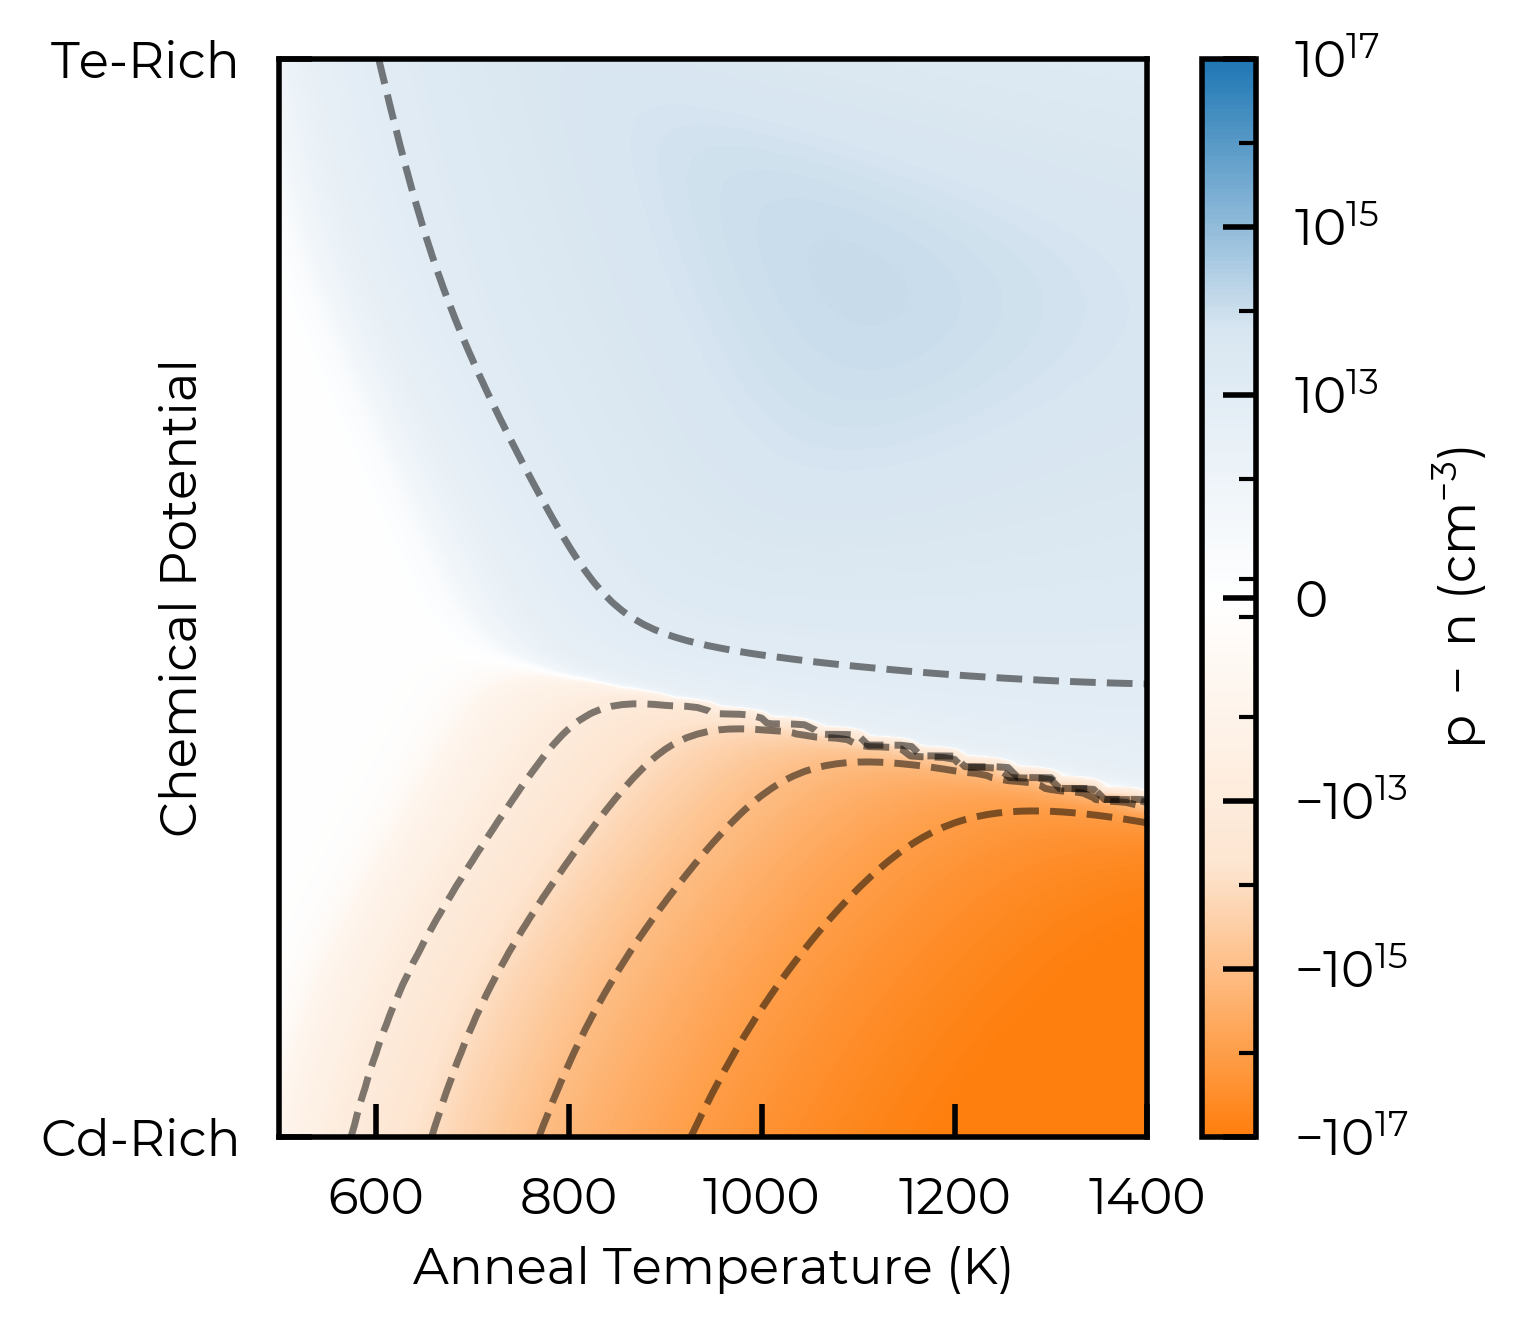

In [28]:
import matplotlib
from matplotlib.colors import SymLogNorm
# plot carrier concentrations as a 2D heatmap

f,ax = plt.subplots()
# define diverging colourmap, from blue to white to orange, quadratically:
colour_list = ["C0", "#D8E6F1", "white", "#FDE5D0", "C1"]
colour_list.reverse()  # of course can use any other colourmap of your choosing here
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colour_list)
mappable = ax.imshow(
    doping_concentration.reshape(len(chempot_x), len(anneal_temperatures)),
    extent=[min(anneal_temperatures), max(anneal_temperatures), min(chempot_x), max(chempot_x)],  # reverse y axis
    aspect="auto", origin="lower", cmap=cmap, interpolation="gaussian", 
    norm=SymLogNorm(linthresh=5e11, vmin=-1e17, vmax=1e17))  # set normalisation of colourmap

# add contour lines at p = 1e13, n = 1e13, 1e14, 1e15, 1e16 to help illustrate:
ax.contour(anneal_temperatures, chempot_x,
           doping_concentration.reshape(len(chempot_x), len(anneal_temperatures)),
           levels=[-1e16, -1e15, -1e14, -1e13], colors="k", alpha=0.5, linestyles="--")
ax.contour(anneal_temperatures, chempot_x,
           doping_concentration.reshape(len(chempot_x), len(anneal_temperatures)),
           levels=[1e13, ], colors="k", alpha=0.5, linestyles="--")

ax.set_xlim(500, 1400); ax.set_yticks([0, 1])
ax.set_yticklabels(["Cd-Rich", "Te-Rich"])  # here Te-poor = Cd-rich

cbar = f.colorbar(mappable, ax=ax, ticks=[-1e17, -1e15, -1e13, 0, 1e13, 1e15, 1e17])
cbar.set_label(r"$p\ -\ n$ (cm$^{-3}$)")  # add and label colourbar
ax.set_xlabel("Anneal Temperature (K)"); ax.set_ylabel("Chemical Potential", labelpad=-30);

Here we see that while a greater portion of chemical potential & temperature space for _intrinsic_ CdTe results in _p_type doping, the hole concentration remains relatively low, just above $10^{13}$ cm$^{-3}$. Under Cd-rich conditions on the other hand, we obtain much higher electron carrier concentrations (~$10^{17}$ cm$^{-3}$ at high temperatures).

We can perform similar heatmap analyses of specific defect concentrations, Fermi level positions etc.

## CdTe: Defect Concentrations vs μ

Finally, let's plot the defect concentrations as a function of chemical potential, at a fixed annealing temperature of 900 K:

In [29]:
dict_list_900K = [d for d in dict_list if d[1] == 900]  # select dicts for 900K annealing
dict_array_vals_900K = {k: [
    conc_dict[k] for conc_dict in np.array(dict_list_900K)[:, 2]] for k in dict_list_900K[0][2].keys()}

In [30]:
conc_df_array_900K = dict_array_vals_900K["conc_df"]

In [31]:
defect_conc_dict_900K = {
    defect: np.array([
        conc_df_array_900K[i]["Total Concentration (cm^-3)"][
            conc_df_array_900K[0]["Defect"] == defect].to_numpy()[0] 
        for i in range(len(conc_df_array_900K))]) for defect in conc_df_array_900K[0]["Defect"]
}

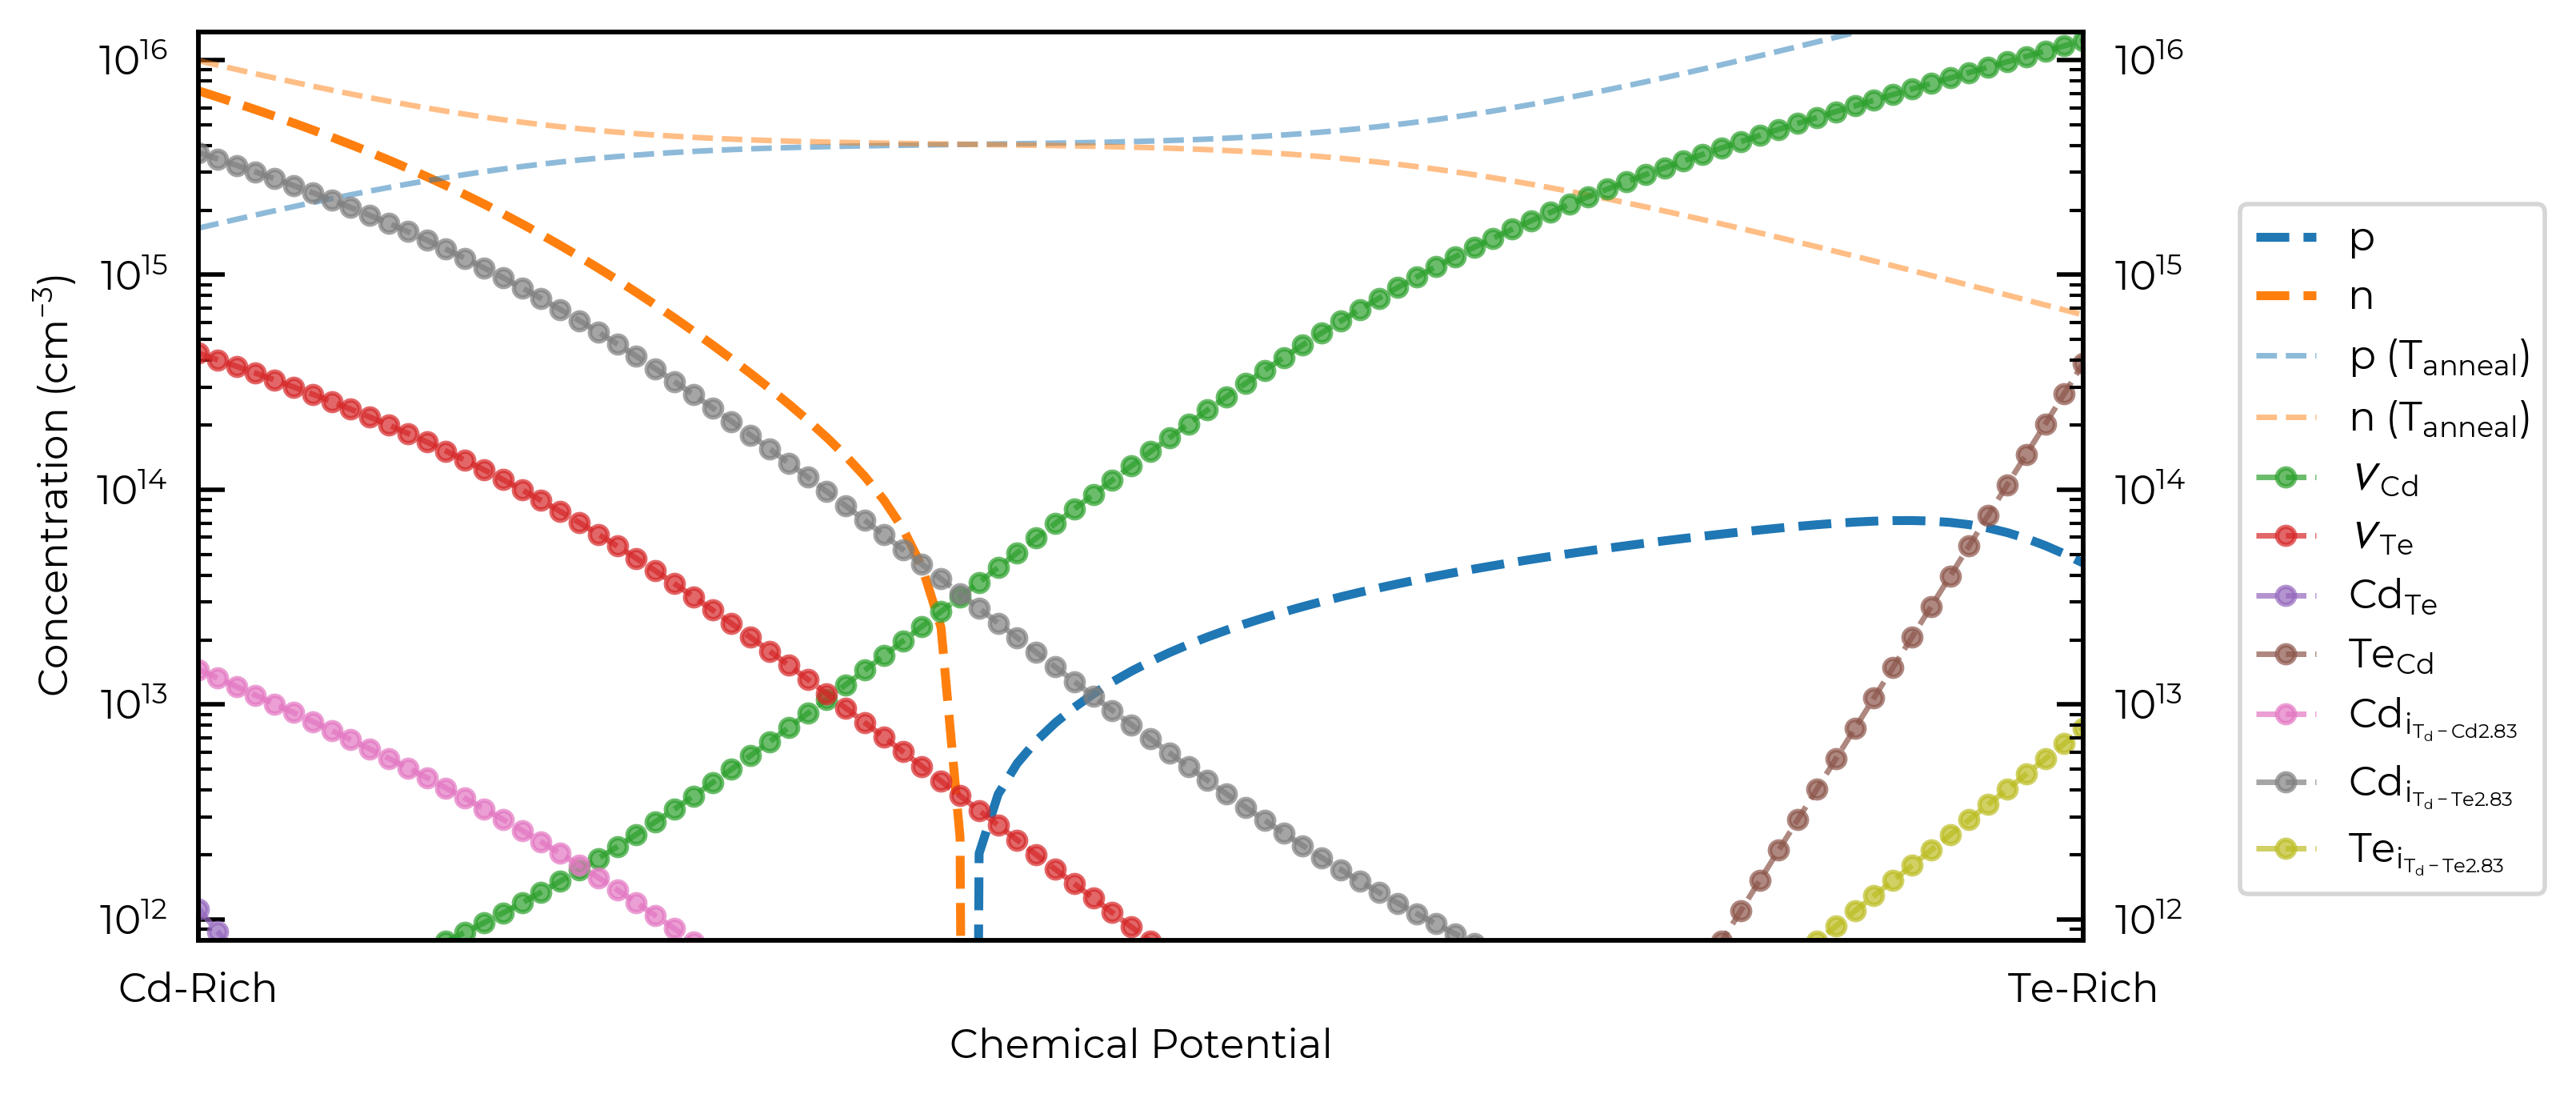

In [32]:
f, ax = plt.subplots(figsize=(7,3.5))

plt.rcParams["lines.markersize"] = 4
ax.plot(chempot_x, dict_array_vals_900K["h_conc"], label='p', lw=2, linestyle="--") 
ax.plot(chempot_x, dict_array_vals_900K["e_conc"], label='n', lw=2, linestyle="--")
ax.plot(chempot_x, dict_array_vals_900K["annealing_h_conc"], 
        label='p ($T_{anneal}$)', c="C0", linestyle="--", alpha=0.5)
ax.plot(chempot_x, dict_array_vals_900K["annealing_e_conc"], 
        label='n ($T_{anneal}$)', c="C1", linestyle="--", alpha=0.5)

for defect, conc_array in defect_conc_dict_900K.items():
    ax.plot(chempot_x, conc_array, 
            label=format_defect_name(defect, include_site_info_in_name=True, wout_charge=True), alpha=0.7, linestyle="--", marker="o")

ax.set_xlabel("Chemical Potential"); ax.set_ylabel(r"Concentration (cm$^{-3}$)")
ax.set_yscale("log"); ax.set_xlim(0, 1); ax.set_ylim(8e11, 1.35e16)
ax.set_xticks([0,1]); ax.set_xticklabels(["Cd-Rich", "Te-Rich"])  # here Te-poor = Cd-rich

# add ticks and ticklabels on both left and right yaxis:
ax3 = ax.twinx(); ax3.set_ylim(8e11, 1.35e16); ax3.set_yscale("log")
f.legend(loc="right", bbox_to_anchor=(1.15, 0.5))
plt.tight_layout()

```{tip}
Note that the effects of metastable defect states on defect & carrier concentrations are included in this analysis, where they may have significant concentrations particularly at elevated annealing temperatures, contributing to the 'effective degeneracy' and thus overall concentration of the defect species.
```

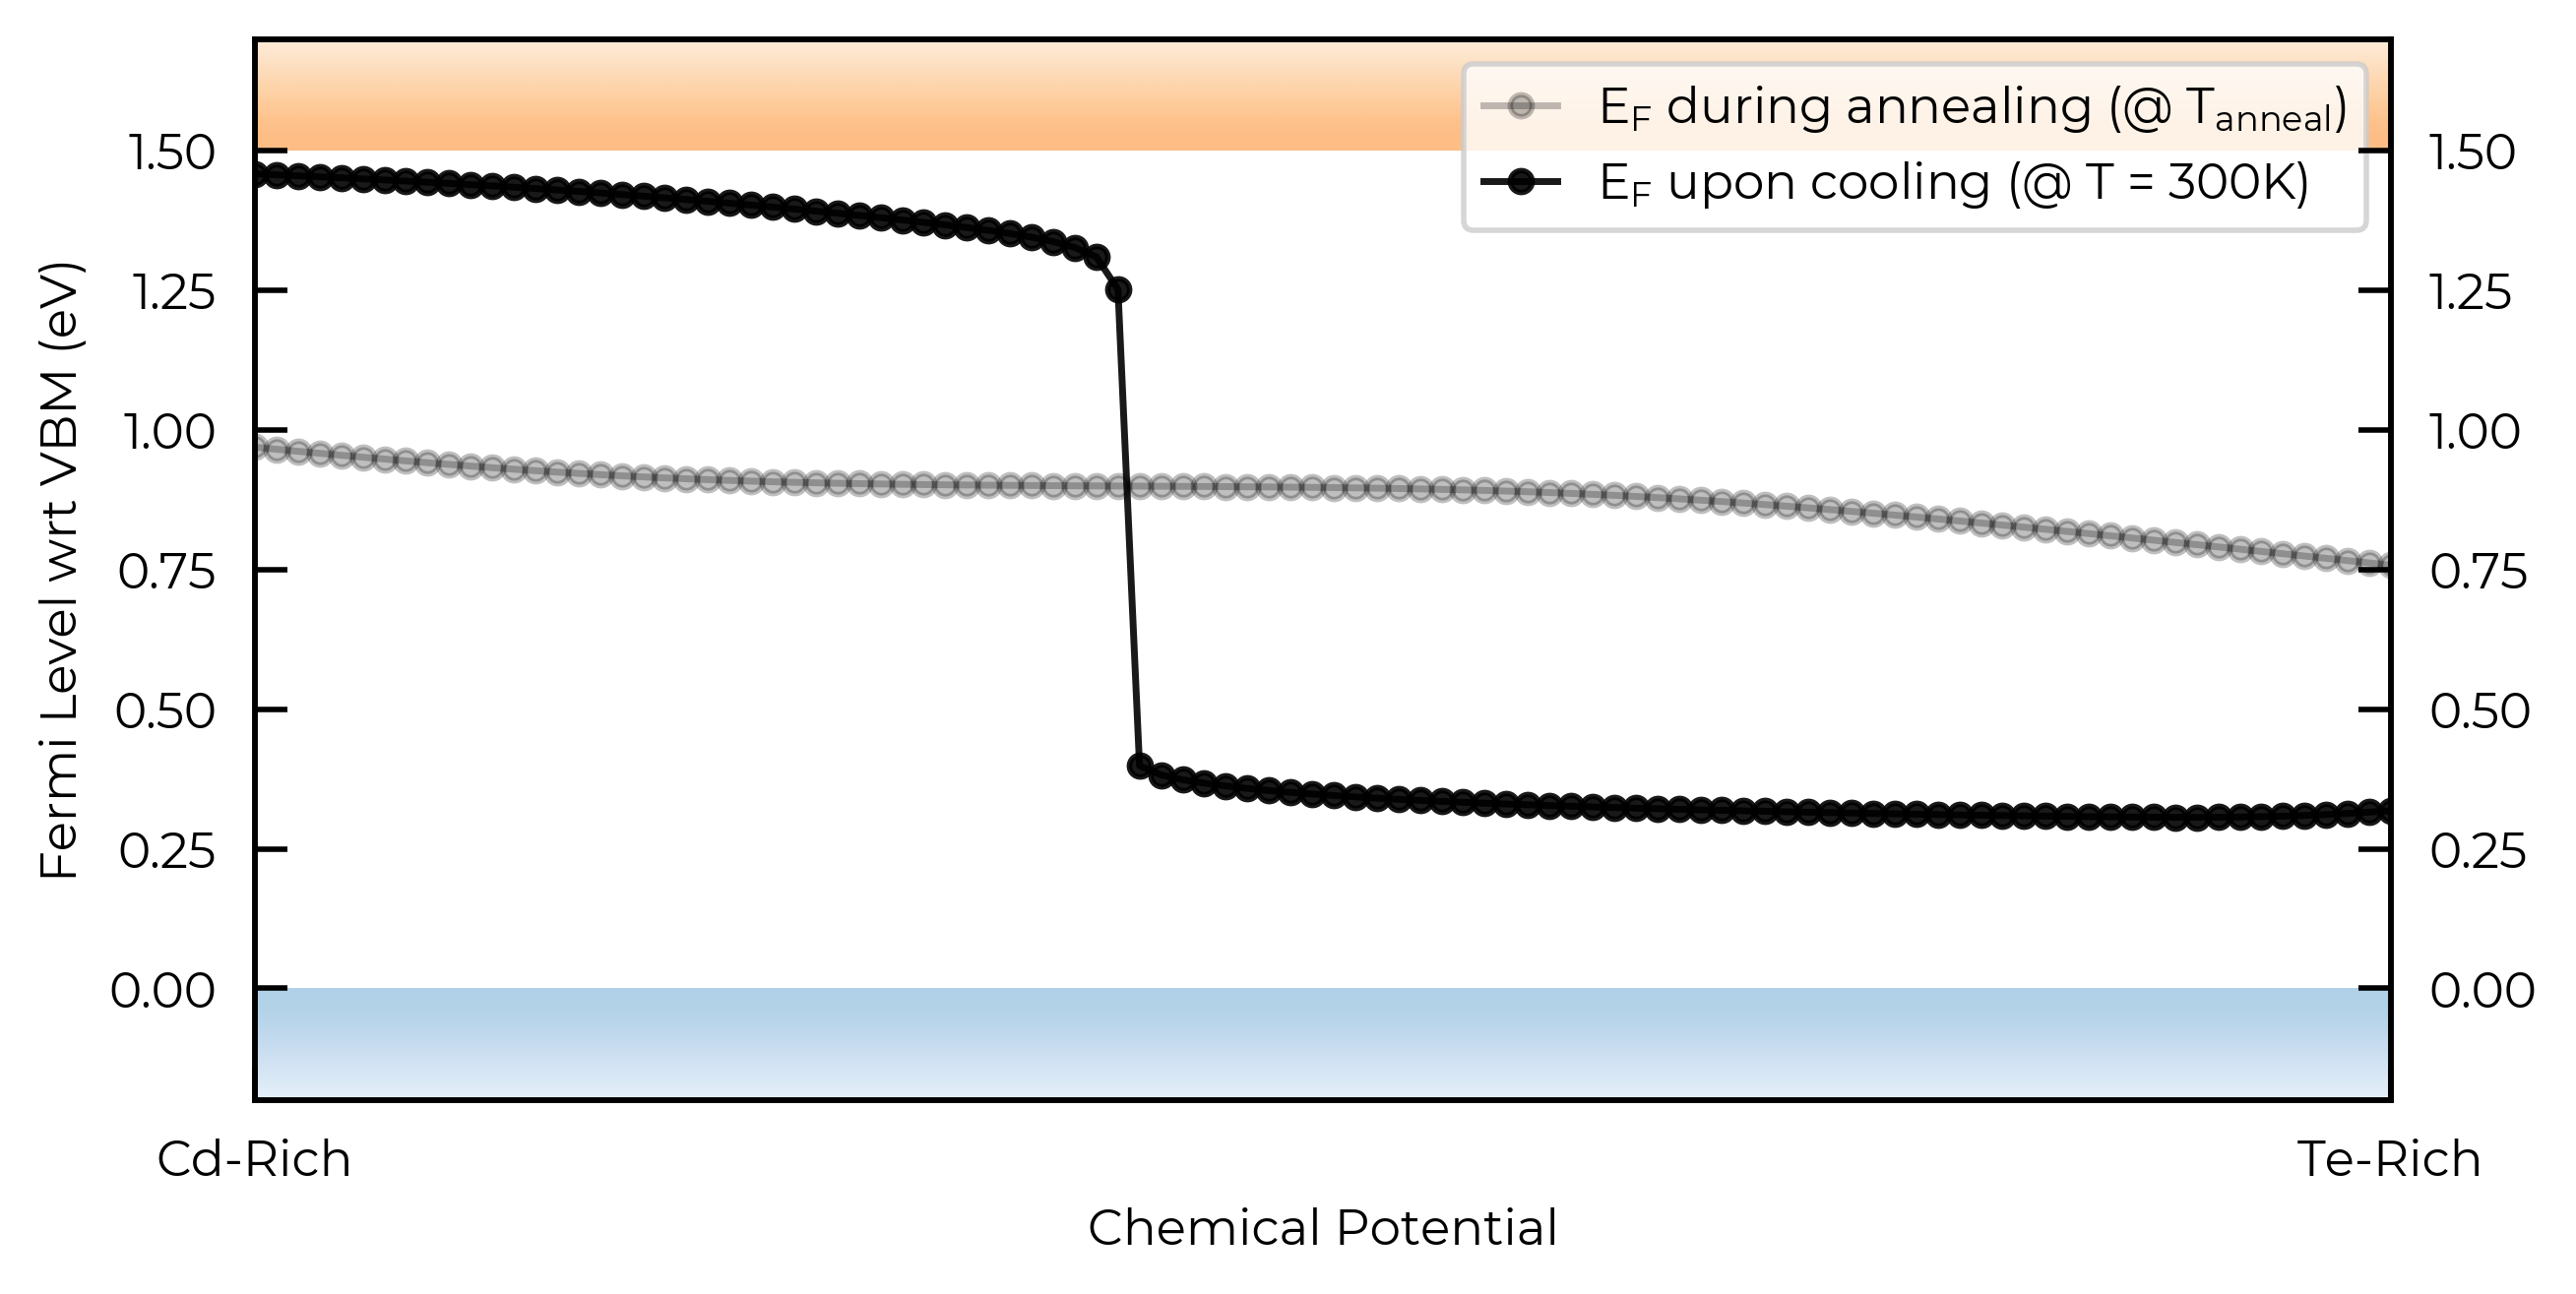

In [33]:
f,ax = plt.subplots(figsize=(7, 3.5))

ax.plot(chempot_x, dict_array_vals_900K["annealing_fermi_level"], marker='o',
        label="$E_F$ during annealing (@ $T_{anneal}$)", color = "k", alpha=0.25)
ax.plot(chempot_x, dict_array_vals_900K["fermi_level"], marker='o',
        label="$E_F$ upon cooling (@ $T$ = 300K)", color = "k", alpha=0.9)

ax.set_xlabel("Chemical Potential"); ax.set_ylabel('Fermi Level wrt VBM (eV)') 
ax.set_xlim(0, 1); ax.set_xticks([0, 1]) 
ax.set_xticklabels(["Cd-Rich", "Te-Rich"])  # here Te-poor = Cd-rich

ax3 = ax.twinx(); ax3.set_ylim(-0.2, 1.7)  # show tick labels on both sides
ax.set_ylim(-0.2, 1.7); ax.legend()

# show VB in blue and CB in orange:
ax.imshow([(1, 1), (0, 0)], cmap=plt.cm.Blues, extent=(ax.get_xlim()[0], ax.get_xlim()[1], -0.3, 0),
          vmin=0, vmax=3, interpolation="bicubic", rasterized=True, aspect="auto")
ax.imshow([(0, 0,), (1, 1)], cmap=plt.cm.Oranges, extent=(ax.get_xlim()[0], ax.get_xlim()[1], 1.5, 1.8),
          vmin=0, vmax=3, interpolation="bicubic", rasterized=True, aspect="auto",)
plt.show()

## Notes

```{important}
We can perform all this analysis when we have included extrinsic defects in our calculated defect dataset as well, in order to investigate the predicted doping behaviour of extrinsic species.
```

```{tip}
The ’frozen defect’ approximation illustrated in these examples may not be totally applicable in cases where the material is slowly cooled from the annealing temperatures (allowing quasi-equilibrium to be attained at lower temperatures) or for highly-mobile defects which can migrate and potentially annihilate at room/operating temperatures (e.g. Li in battery materials). 

In such cases, more detailed/complex models are required to accurately predict the defect and carrier thermodynamics and electronic response. The [`py-sc-fermi`](https://py-sc-fermi.readthedocs.io/en/latest) package can be used for these more complex analyses, for which the defect formation energies from `doped` can be readily imported.
```